Notes:

Data: http://data.healthybrainnetwork.org/ (LORIS, all_with_new_diag_and_nih query)

Diagnosis is contained in the "Diagnosis_ClinicianConsensus" column (not in "ConsensusDx")

Diagnoses to predict:

- Specific Learning Disorder with Impairment in Reading
- Specific Learning Disorder with Impairment in Mathematics
- Intellectual Disability-Mild 
- Borderline Intellectual Functioning
- Specific Learning Disorder with Impairment in Written Expression


In [95]:
import pandas as pd
import numpy as np
from collections import Counter
from re import M
import os
import matplotlib.pyplot as plt

data_output_dir = "data/output/"
if not os.path.exists(data_output_dir):
    os.mkdir(data_output_dir)

data_intermediate_dir = "data/intermediate/"
if not os.path.exists(data_intermediate_dir):
    os.mkdir(data_intermediate_dir)
    
pd.set_option("display.max_columns", None)

## Read and prepare data

In [96]:
# LORIS saved query (all data)
full = pd.read_csv("data/LORIS-release-10.csv", dtype=object)
len(full.index)

7244

In [97]:
# Replace NaN (currently ".") values with np.nan
full = full.replace(".", np.nan)

In [98]:
# Drop first row (doesn't have ID)
full = full.iloc[1: , :]

In [99]:
# Drop empty columns
print(len(full.columns))
cols_before_remove_empty = full.columns
full = full.dropna(how='all', axis=1)
cols_after_remove_empty = full.columns
print(len(full.columns))
print("Empty columns: ")
display(sorted(list(set(cols_before_remove_empty) - set(cols_after_remove_empty))))

7436
6282
Empty columns: 


['ACE,Comment_ID',
 'ACE,PSCID',
 'ACE,Visit_label',
 'ACE,\ufeffEID',
 'APPLEQUAN""',
 'APPLSCQUAN""',
 'APQ_P,Comment_ID',
 'APQ_P,PSCID',
 'APQ_P,Visit_label',
 'APQ_P,\ufeffEID',
 'APQ_SR,Comment_ID',
 'APQ_SR,PSCID',
 'APQ_SR,Visit_label',
 'APQ_SR,\ufeffEID',
 'ARI_P,Comment_ID',
 'ARI_P,PSCID',
 'ARI_P,Visit_label',
 'ARI_P,\ufeffEID',
 'ARI_S,Comment_ID',
 'ARI_S,PSCID',
 'ARI_S,Visit_label',
 'ARI_S,\ufeffEID',
 'ASR,Comment_ID',
 'ASR,PSCID',
 'ASR,Visit_label',
 'ASR,\ufeffEID',
 'ASSQ,Comment_ID',
 'ASSQ,PSCID',
 'ASSQ,Visit_label',
 'ASSQ,\ufeffEID',
 'Acc""',
 'Act_Sev_10""',
 'Age""',
 'Area_Head""',
 'Attentive""',
 'Audit,Comment_ID',
 'Audit,PSCID',
 'Audit,Visit_label',
 'Audit,\ufeffEID',
 'BIA,"Activity_Level",BIA',
 'BIA,"BMC",BIA',
 'BIA,"BMR",BIA',
 'BIA,"Days_Baseline",BIA',
 'BIA,"EID",BIA',
 'BIA,"FFMI",BIA',
 'BIA,"Fat",BIA',
 'BIA,"Height",BIA',
 'BIA,"LDM",BIA',
 'BIA,"SMM",BIA',
 'BIA,"Season",BIA',
 'BIA,"Study",BIA',
 'BIA,"TBW",BIA',
 'BIA,"Year",BIA',

In [100]:
# Investigate columns per assessement
display(full[[x for x in full.columns if x.startswith("ACE,")]].columns)

Index(['ACE,ACE_01', 'ACE,ACE_02', 'ACE,ACE_03', 'ACE,ACE_04', 'ACE,ACE_05',
       'ACE,ACE_06', 'ACE,ACE_07', 'ACE,ACE_08', 'ACE,ACE_09', 'ACE,ACE_10',
       'ACE,ACE_Score', 'ACE,Administration', 'ACE,Data_entry',
       'ACE,Days_Baseline', 'ACE,EID', 'ACE,START_DATE', 'ACE,Season',
       'ACE,Site', 'ACE,Study', 'ACE,Year'],
      dtype='object')

In [102]:
# Remove irrelevant NIH toolbox columns

NIH_cols = [x for x in full.columns if "NIH" in x]
NIH_assessments = set([x.split(",")[0] for x in NIH_cols])
print(NIH_assessments)
NIH_scores_cols = [x for x in NIH_cols if x.startswith("NIH_Scores,")]
display(full[NIH_scores_cols].columns)

# Drop percentile scores, only keep actual score
NIH_cols_to_drop = [x for x in NIH_scores_cols if x.endswith("_P")]
full = full.drop(NIH_cols_to_drop, axis = 1)

# Drop non-numeric columns
full = full.drop(["NIH_Scores,NIH7_Incomplete_Reason"], axis = 1)

full[[x for x in full.columns if x.startswith("NIH_Scores,")]].columns

{'NIH_Scores', 'NIH', 'NIH_final'}


Index(['NIH_Scores,Administration', 'NIH_Scores,Data_entry',
       'NIH_Scores,Days_Baseline', 'NIH_Scores,EID', 'NIH_Scores,NIH7_Card',
       'NIH_Scores,NIH7_Comp', 'NIH_Scores,NIH7_Complete',
       'NIH_Scores,NIH7_Flanker', 'NIH_Scores,NIH7_List',
       'NIH_Scores,NIH7_Pattern', 'NIH_Scores,NIH7_Picture',
       'NIH_Scores,START_DATE', 'NIH_Scores,Season', 'NIH_Scores,Site',
       'NIH_Scores,Study', 'NIH_Scores,Year'],
      dtype='object')

KeyError: "['NIH_Scores,NIH7_Incomplete_Reason'] not found in axis"

In [103]:
# Investigate diagnosis columns
display(full[[x for x in full.columns if x.startswith("Diagnosis_ClinicianConsensus,")]].columns)
print(len(full[[x for x in full.columns if x.startswith("Diagnosis_ClinicianConsensus,")]].columns))
display(full[[x for x in full.columns if x.startswith("Diagnosis_ClinicianConsensus,DX_01")]].columns)

Index(['Diagnosis_ClinicianConsensus,Administration',
       'Diagnosis_ClinicianConsensus,DX_01',
       'Diagnosis_ClinicianConsensus,DX_01_ByHx',
       'Diagnosis_ClinicianConsensus,DX_01_Cat',
       'Diagnosis_ClinicianConsensus,DX_01_Code',
       'Diagnosis_ClinicianConsensus,DX_01_Confirmed',
       'Diagnosis_ClinicianConsensus,DX_01_New',
       'Diagnosis_ClinicianConsensus,DX_01_PRem',
       'Diagnosis_ClinicianConsensus,DX_01_Past_Doc',
       'Diagnosis_ClinicianConsensus,DX_01_Presum',
       ...
       'Diagnosis_ClinicianConsensus,DX_10_Sub',
       'Diagnosis_ClinicianConsensus,DX_10_Time',
       'Diagnosis_ClinicianConsensus,Data_entry',
       'Diagnosis_ClinicianConsensus,EID', 'Diagnosis_ClinicianConsensus,NoDX',
       'Diagnosis_ClinicianConsensus,START_DATE',
       'Diagnosis_ClinicianConsensus,Season',
       'Diagnosis_ClinicianConsensus,Site',
       'Diagnosis_ClinicianConsensus,Study',
       'Diagnosis_ClinicianConsensus,Year'],
      dtype='object', 

159


Index(['Diagnosis_ClinicianConsensus,DX_01',
       'Diagnosis_ClinicianConsensus,DX_01_ByHx',
       'Diagnosis_ClinicianConsensus,DX_01_Cat',
       'Diagnosis_ClinicianConsensus,DX_01_Code',
       'Diagnosis_ClinicianConsensus,DX_01_Confirmed',
       'Diagnosis_ClinicianConsensus,DX_01_New',
       'Diagnosis_ClinicianConsensus,DX_01_PRem',
       'Diagnosis_ClinicianConsensus,DX_01_Past_Doc',
       'Diagnosis_ClinicianConsensus,DX_01_Presum',
       'Diagnosis_ClinicianConsensus,DX_01_RC',
       'Diagnosis_ClinicianConsensus,DX_01_Rem',
       'Diagnosis_ClinicianConsensus,DX_01_RuleOut',
       'Diagnosis_ClinicianConsensus,DX_01_Spec',
       'Diagnosis_ClinicianConsensus,DX_01_Sub',
       'Diagnosis_ClinicianConsensus,DX_01_Time'],
      dtype='object')

In [104]:
# Remove uninteresting columns
columns_to_drop = []

column_suffixes_to_drop = ["Administration", "Data_entry", "Days_Baseline", "START_DATE", "Season", "Site", "Study", "Year", "Commercial_Use", "Release_Number"]
for suffix in column_suffixes_to_drop:
    cols_w_suffix = [x for x in full.columns if suffix in x]
    columns_to_drop.extend(cols_w_suffix)

present_columns_to_drop = full.filter(columns_to_drop)
print(len(full.columns))
full = full.drop(present_columns_to_drop, axis = 1)
print(len(full.columns))

6275
5420


In [105]:
# Check which columns have weird column names with quotes, like: "BIA,"Year",BIA"
cols_w_broken_quotes = [x for x in full.columns if ('"') in x] 
cols_w_broken_quotes

[]

In [106]:
# Remove questionnaires with broken quotes
full = full.drop(cols_w_broken_quotes, axis=1)

In [107]:
# Check if there is a EID column
EID_cols = [x for x in full.columns if ",EID" in x]
EID_cols

['ACE,EID',
 'APQ_P,EID',
 'APQ_SR,EID',
 'ARI_P,EID',
 'ARI_S,EID',
 'ASR,EID',
 'ASSQ,EID',
 'Audit,EID',
 'BIA,EID',
 'Barratt,EID',
 'Basic_Demos,EID',
 'C3SR,EID',
 'CAARS,EID',
 'CBCL,EID',
 'CBCL_Pre,EID',
 'CCSC,EID',
 'CDI_P,EID',
 'CDI_SR,EID',
 'CELF,EID',
 'CELF5_Meta,EID',
 'CELF_Full_5to8,EID',
 'CELF_Full_9to21,EID',
 'CELF_Meta,EID',
 'CGAS,EID',
 'CIS_P,EID',
 'CIS_SR,EID',
 'CPIC,EID',
 'CTOPP,EID',
 'ColorVision,EID',
 'ConsensusDx,EID',
 'DTS,EID',
 'DailyMeds,EID',
 'Diagnosis_ClinicianConsensus,EID',
 'DigitSpan,EID',
 'DrugScreen,EID',
 'EEG_Track,EID',
 'EHQ,EID',
 'ESPAD,EID',
 'ESWAN,EID',
 'EVT,EID',
 'FFQ,EID',
 'FGC,EID',
 'FSQ,EID',
 'FTND,EID',
 'FTQA,EID',
 'GFTA,EID',
 'IAT,EID',
 'ICU_P,EID',
 'KBIT,EID',
 'MFQ_P,EID',
 'MFQ_SR,EID',
 'MRI_Track,EID',
 'NIDA,EID',
 'NIH,EID',
 'NIH_Scores,EID',
 'NIH_final,EID',
 'NLES_P,EID',
 'NLES_SR,EID',
 'PAQ_A,EID',
 'PAQ_C,EID',
 'PBQ,EID',
 'PCIAT,EID',
 'PPS,EID',
 'PPVT,EID',
 'PSI,EID',
 'Pegboard,EID',
 'P

In [108]:
# Check if EID is equal among the questionnaires in one row
full_for_EID_check = full[EID_cols]

## Fill missing EIDs with EIDs from other questionnaires 
full_for_EID_check = full_for_EID_check.ffill(axis=1).bfill(axis=1)

## Check if the EID of all columns are equal to EID of the first column
print(full_for_EID_check.eq(full_for_EID_check.iloc[:, 0], axis=0).all(1).value_counts())

# Remove 16 lines with different EID within one row
print(len(full))
full = full[full_for_EID_check.eq(full_for_EID_check.iloc[:, 0], axis=0).all(1)]
print(len(full))

# ==> EID of each questionnaire are the same in a row, can use the first non-empty one as an ID

True     7227
False      16
dtype: int64
7243
7227


In [109]:
# Fill ID field with the first non-null questionnaire-specific EID
full["ID"] = full_for_EID_check.iloc[:, 0]
print(len(full.index))

7227


In [110]:
# Check if # of unique IDs is the same as number of subjects in the release
print(len(full["ID"].unique()))

7227


In [111]:
# Check which questionnaires are present in the rows with unserscores (NDARZZ007YMP_1, NDARAA075AMK_Visit_1)
rows_with_underscore_in_id = full[full["ID"].str.contains("_")]
non_empty_columns_in_underscore = rows_with_underscore_in_id.columns[
    ~rows_with_underscore_in_id.isna().all()].tolist() 
non_empty_questionnaires_in_underscore = set([x.split(",")[0] for x in non_empty_columns_in_underscore])
print("Non empty questionnaires in rows with underscores in EID: ", non_empty_questionnaires_in_underscore)

# Drop rows with underscores
non_empty_questionnaires_in_underscore.remove("Identifiers")
non_empty_questionnaires_in_underscore.remove("ID")
full_wo_underscore = full[~full["ID"].str.contains("_")]

# Drop questionnaires present in rows with underscores from data ({'DailyMeds', 'TRF', 'TRF_P', 'TRF_Pre'})
for questionnaire in non_empty_questionnaires_in_underscore:
    full_wo_underscore = full_wo_underscore.drop(full_wo_underscore.filter(regex=(questionnaire+",")), axis=1)
    
# Drop questionnaires present in rows with underscores from data from list of ID columns (will be used to check if an assessment is filled)
EID_cols = [x for x in EID_cols if 'TRF' not in x]
EID_cols = [x for x in EID_cols if 'DailyMeds' not in x]

print(len(full_wo_underscore.index))
print(len(full_wo_underscore["ID"].unique()))

Non empty questionnaires in rows with underscores in EID:  {'TRF', 'TRF_P', 'ID', 'TRF_Pre', 'DailyMeds', 'Identifiers'}
4146
4146


In [112]:
# Remove incomplete DX and missing DX

full_wo_underscore = full_wo_underscore[full_wo_underscore["Diagnosis_ClinicianConsensus,DX_01"] != "No Diagnosis Given: Incomplete Eval"]
full_wo_underscore = full_wo_underscore[full_wo_underscore["Diagnosis_ClinicianConsensus,EID"].notna()]
full_wo_underscore["ID"].nunique()

3613

In [113]:
# Get list of assessments in data
assessment_list = set([x.split(",")[0] for x in EID_cols])

# Get assessments most people filled
pd.set_option('display.max_rows', None)
assessment_answer_counts = full_wo_underscore[EID_cols].count().sort_values(ascending=False).to_frame()
assessment_answer_counts["Ratio"] = assessment_answer_counts[0]/full_wo_underscore["ID"].nunique()*100
assessment_answer_counts.columns = ["N of Participants", "% of Participants Filled"]
display(assessment_answer_counts)

assessment_answer_counts.to_csv("data/output/assessment_filled_distrib.csv")

,N of Participants,% of Participants Filled
"Diagnosis_ClinicianConsensus,EID",3613,100.000000
"Basic_Demos,EID",3613,100.000000
"PreInt_EduHx,EID",3603,99.723222
"PreInt_DevHx,EID",3601,99.667866
"NIH_Scores,EID",3600,99.640188
"PreInt_TxHx,EID",3593,99.446443
"WIAT,EID",3592,99.418766
"Pegboard,EID",3568,98.754498
"SympChck,EID",3562,98.588431
"SCQ,EID",3561,98.560753


In [114]:
# Get list of assessments sorted by popularity
EID_columns_by_popularity = assessment_answer_counts.index

# Only include relevant cognitive testing, Questionnaire Measures of Emotional and Cognitive Status, and Questionnaire Measures of Family Structure, Stress, and Trauma
relevant_EID_list = [x+",EID" for x in ["Basic_Demos", "WIAT", "NIH_Scores", "SympChck", "SCQ", "Barratt", "ASSQ", "ARI_P", "SDQ", "SWAN", "SRS", "CBCL", "ICU_P", "APQ_P", "PCIAT", "DTS", "ESWAN", "MFQ_P", "APQ_SR", "WISC", "WHODAS_P", "CIS_P", "PSI", "RBS", "PhenX_Neighborhood", "WHODAS_SR", "CIS_SR", "SCARED_SR", "C3SR", "CCSC", "CPIC", "YSR", "PhenX_SchoolRisk", "CBCL_Pre", "SRS_Pre", "ASR"]]
EID_columns_by_popularity = [x for x in EID_columns_by_popularity if x in relevant_EID_list]

In [115]:
# Get number of people who took all top 1, top 2, top 3, etc. popular assessments (cumulative assessment distribution)
cumul_number_of_examples_list = []
for i in range(1, len(EID_columns_by_popularity)+1):
    columns = EID_columns_by_popularity[0:i] # top i assessments
    cumul_number_of_examples = full_wo_underscore[columns].notnull().all(axis=1).sum()
    cumul_number_of_examples_list.append([cumul_number_of_examples, [x.split(",")[0] for x in columns]])
cumul_number_of_examples_df = pd.DataFrame(cumul_number_of_examples_list)
cumul_number_of_examples_df.columns = ("Respondents", "Assessments")
cumul_number_of_examples_df.to_csv("data/output/assessment_filled_distrib_cumul.csv")

,Respondents,Assessments,N of Assessments,Last Assessment
0,3613,[Basic_Demos],1,Basic_Demos
1,3600,"[Basic_Demos, NIH_Scores]",2,NIH_Scores
2,3583,"[Basic_Demos, NIH_Scores, WIAT]",3,WIAT
3,3536,"[Basic_Demos, NIH_Scores, WIAT, SympChck]",4,SympChck
4,3526,"[Basic_Demos, NIH_Scores, WIAT, SympChck, SCQ]",5,SCQ
5,3492,"[Basic_Demos, NIH_Scores, WIAT, SympChck, SCQ,...",6,Barratt
6,3475,"[Basic_Demos, NIH_Scores, WIAT, SympChck, SCQ,...",7,ASSQ
7,3442,"[Basic_Demos, NIH_Scores, WIAT, SympChck, SCQ,...",8,ARI_P
8,3400,"[Basic_Demos, NIH_Scores, WIAT, SympChck, SCQ,...",9,SDQ
9,3328,"[Basic_Demos, NIH_Scores, WIAT, SympChck, SCQ,...",10,SWAN


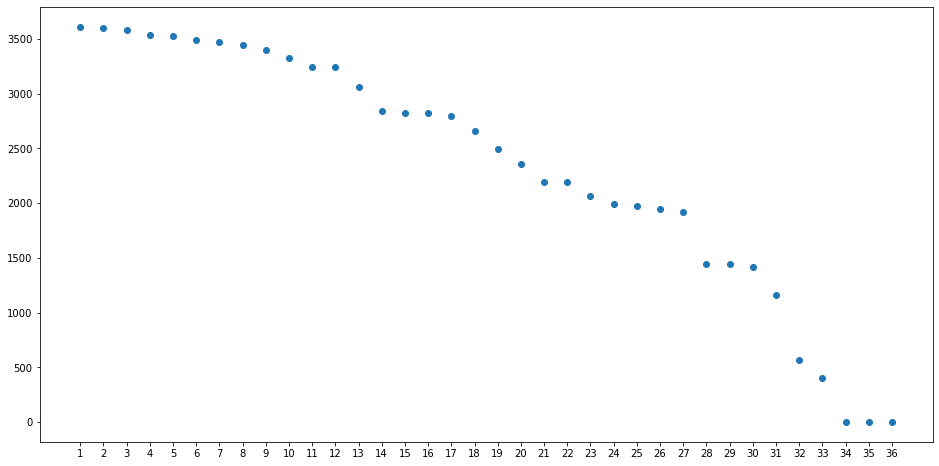

In [116]:
cumul_number_of_examples_df["N of Assessments"] = cumul_number_of_examples_df["Assessments"].str.len()
cumul_number_of_examples_df["Last Assessment"] = cumul_number_of_examples_df["Assessments"].str[-1]
display(cumul_number_of_examples_df)
plt.figure(figsize=(16,8))
plt.xticks(cumul_number_of_examples_df["N of Assessments"])
plt.scatter(cumul_number_of_examples_df["N of Assessments"], cumul_number_of_examples_df["Respondents"])
plt.show()

In [117]:
# List of most popular assessments until the first one with an age restriction
EID_columns_until_SCARED = [x for x in EID_columns_by_popularity[:EID_columns_by_popularity.index("SCARED_SR,EID")]]
EID_columns_until_SCARED

['Basic_Demos,EID',
 'NIH_Scores,EID',
 'WIAT,EID',
 'SympChck,EID',
 'SCQ,EID',
 'Barratt,EID',
 'ASSQ,EID',
 'ARI_P,EID',
 'SDQ,EID',
 'SWAN,EID',
 'SRS,EID',
 'CBCL,EID',
 'ICU_P,EID',
 'APQ_P,EID',
 'PCIAT,EID',
 'DTS,EID',
 'ESWAN,EID',
 'MFQ_P,EID',
 'APQ_SR,EID',
 'WISC,EID',
 'WHODAS_P,EID',
 'CIS_P,EID',
 'PSI,EID',
 'RBS,EID',
 'PhenX_Neighborhood,EID',
 'WHODAS_SR,EID',
 'CIS_SR,EID']

In [118]:
# Get only people who took the most popular assessments until the first one with an age restriction (SCARED_SR)
columns_until_SCARED = []
assessments_until_SCARED = [x.split(",")[0]+"," for x in EID_columns_until_SCARED]
for assessment in assessments_until_SCARED:
    columns = [column for column in full_wo_underscore.columns if column.startswith(assessment)]
    columns_until_SCARED.extend(columns)
    
diag_colunms = ["Diagnosis_ClinicianConsensus,DX_01", "Diagnosis_ClinicianConsensus,DX_02", "Diagnosis_ClinicianConsensus,DX_03", "Diagnosis_ClinicianConsensus,DX_04", "Diagnosis_ClinicianConsensus,DX_05", "Diagnosis_ClinicianConsensus,DX_06", "Diagnosis_ClinicianConsensus,DX_07", "Diagnosis_ClinicianConsensus,DX_08", "Diagnosis_ClinicianConsensus,DX_09", "Diagnosis_ClinicianConsensus,DX_10"]
data_up_to_SCARED = full_wo_underscore.loc[full_wo_underscore[EID_columns_until_SCARED].dropna(how="any").index][columns_until_SCARED+["ID"]+diag_colunms]

# Remove EID columns: not needed anymore
data_up_to_SCARED = data_up_to_SCARED.drop(EID_columns_until_SCARED, axis=1)

In [119]:
# Remove non-used output columns
print([x for x in data_up_to_SCARED.columns if "WIAT" in x])
WIAT_cols_to_keep = ["WIAT,WIAT_Word_Stnd", "WIAT,WIAT_Num_Stnd"]
WIAT_cols_to_drop = [x for x in data_up_to_SCARED.columns if "WIAT" in x and x not in WIAT_cols_to_keep] 
data_up_to_SCARED = data_up_to_SCARED.drop(WIAT_cols_to_drop, axis=1)
print([x for x in data_up_to_SCARED.columns if "WIAT" in x])

print([x for x in data_up_to_SCARED.columns if "WISC" in x])
WISC_cols_to_keep = ["WISC,WISC_Coding_Scaled", "WISC,WISC_SS_Scaled", "WISC,WISC_FSIQ"]
WISC_cols_to_drop = [x for x in data_up_to_SCARED.columns if "WISC" in x and x not in WISC_cols_to_keep] 
data_up_to_SCARED = data_up_to_SCARED.drop(WISC_cols_to_drop, axis=1)
print([x for x in data_up_to_SCARED.columns if "WISC" in x])

display(data_up_to_SCARED.iloc[:5,:])

['WIAT,WIAT_Complete', 'WIAT,WIAT_Incomplete_reason', 'WIAT,WIAT_Invalid_Reason', 'WIAT,WIAT_LCODC_P', 'WIAT,WIAT_LCODC_Raw', 'WIAT,WIAT_LCODC_Stnd', 'WIAT,WIAT_LCRV_P', 'WIAT,WIAT_LCRV_Raw', 'WIAT,WIAT_LCRV_Std', 'WIAT,WIAT_LC_P', 'WIAT,WIAT_LC_Stnd', 'WIAT,WIAT_MP_P', 'WIAT,WIAT_MP_Raw', 'WIAT,WIAT_MP_Stnd', 'WIAT,WIAT_Num_P', 'WIAT,WIAT_Num_Raw', 'WIAT,WIAT_Num_Stnd', 'WIAT,WIAT_Pseudo_P', 'WIAT,WIAT_Pseudo_Raw', 'WIAT,WIAT_Pseudo_Stnd', 'WIAT,WIAT_RC_P', 'WIAT,WIAT_RC_Raw', 'WIAT,WIAT_RC_Stnd', 'WIAT,WIAT_Spell_P', 'WIAT,WIAT_Spell_Raw', 'WIAT,WIAT_Spell_Stnd', 'WIAT,WIAT_Valid', 'WIAT,WIAT_Word_P', 'WIAT,WIAT_Word_Raw', 'WIAT,WIAT_Word_Stnd']
['WIAT,WIAT_Num_Stnd', 'WIAT,WIAT_Word_Stnd']
['WISC,WISC_BD_Raw', 'WISC,WISC_BD_Scaled', 'WISC,WISC_Coding_Raw', 'WISC,WISC_Coding_Scaled', 'WISC,WISC_DS_Raw', 'WISC,WISC_DS_Scaled', 'WISC,WISC_FRI', 'WISC,WISC_FRI_Percentile', 'WISC,WISC_FRI_Sum', 'WISC,WISC_FSIQ', 'WISC,WISC_FSIQ_Percentile', 'WISC,WISC_FSIQ_Sum', 'WISC,WISC_FW_Raw', 'WISC

,"Basic_Demos,Age","Basic_Demos,Sex","NIH_Scores,NIH7_Card","NIH_Scores,NIH7_Comp","NIH_Scores,NIH7_Complete","NIH_Scores,NIH7_Flanker","NIH_Scores,NIH7_List","NIH_Scores,NIH7_Pattern","NIH_Scores,NIH7_Picture","WIAT,WIAT_Num_Stnd","WIAT,WIAT_Word_Stnd","SympChck,CSC_01C","SympChck,CSC_01P","SympChck,CSC_02C","SympChck,CSC_02P","SympChck,CSC_03C","SympChck,CSC_03P","SympChck,CSC_04C","SympChck,CSC_04P","SympChck,CSC_05C","SympChck,CSC_05P","SympChck,CSC_06C","SympChck,CSC_06P","SympChck,CSC_07C","SympChck,CSC_07P","SympChck,CSC_08C","SympChck,CSC_08P","SympChck,CSC_09C","SympChck,CSC_09P","SympChck,CSC_10C","SympChck,CSC_10P","SympChck,CSC_11C","SympChck,CSC_11P","SympChck,CSC_12C","SympChck,CSC_12P","SympChck,CSC_13C","SympChck,CSC_13P","SympChck,CSC_14C","SympChck,CSC_14P","SympChck,CSC_15C","SympChck,CSC_15P","SympChck,CSC_16C","SympChck,CSC_16P","SympChck,CSC_17C","SympChck,CSC_17P","SympChck,CSC_18C","SympChck,CSC_18P","SympChck,CSC_19C","SympChck,CSC_19P","SympChck,CSC_20C","SympChck,CSC_20P","SympChck,CSC_21C","SympChck,CSC_21P","SympChck,CSC_22C","SympChck,CSC_22P","SympChck,CSC_23C","SympChck,CSC_23P","SympChck,CSC_24C","SympChck,CSC_24P","SympChck,CSC_25C","SympChck,CSC_25P","SympChck,CSC_26C","SympChck,CSC_26P","SympChck,CSC_27C","SympChck,CSC_27P","SympChck,CSC_28C","SympChck,CSC_28P","SympChck,CSC_29C","SympChck,CSC_29P","SympChck,CSC_30C","SympChck,CSC_30P","SympChck,CSC_31C","SympChck,CSC_31P","SympChck,CSC_32C","SympChck,CSC_32P","SympChck,CSC_33C","SympChck,CSC_33P","SympChck,CSC_34C","SympChck,CSC_34P","SympChck,CSC_35C","SympChck,CSC_35P","SympChck,CSC_36C","SympChck,CSC_36P","SympChck,CSC_37C","SympChck,CSC_37P","SympChck,CSC_38C","SympChck,CSC_38P","SympChck,CSC_39C","SympChck,CSC_39P","SympChck,CSC_40C","SympChck,CSC_40P","SympChck,CSC_41C","SympChck,CSC_41P","SympChck,CSC_42C","SympChck,CSC_42P","SympChck,CSC_43C","SympChck,CSC_43P","SympChck,CSC_44C","SympChck,CSC_44P","SympChck,CSC_45C","SympChck,CSC_45P","SympChck,CSC_46C","SympChck,CSC_46P","SympChck,CSC_47C","SympChck,CSC_47P","SympChck,CSC_48C","SympChck,CSC_48P","SympChck,CSC_49C","SympChck,CSC_49P","SympChck,CSC_50C","SympChck,CSC_50P","SympChck,CSC_51C","SympChck,CSC_51P","SympChck,CSC_52C","SympChck,CSC_52P","SympChck,CSC_53C","SympChck,CSC_53P","SympChck,CSC_54C","SympChck,CSC_54P","SympChck,CSC_55aC","SympChck,CSC_55aP","SympChck,CSC_55bC","SympChck,CSC_55bP","SympChck,CSC_55cC","SympChck,CSC_55cP","SympChck,CSC_55dC","SympChck,CSC_55dP","SympChck,CSC_55eC","SympChck,CSC_55eP","SympChck,CSC_55fC","SympChck,CSC_55fP","SympChck,CSC_55gC","SympChck,CSC_55gP","SympChck,CSC_55hC","SympChck,CSC_55hP","SympChck,CSC_55iC","SympChck,CSC_55iP","SCQ,SCQ_01","SCQ,SCQ_02","SCQ,SCQ_03","SCQ,SCQ_04","SCQ,SCQ_05","SCQ,SCQ_06","SCQ,SCQ_07","SCQ,SCQ_08","SCQ,SCQ_09","SCQ,SCQ_10","SCQ,SCQ_11","SCQ,SCQ_12","SCQ,SCQ_13","SCQ,SCQ_14","SCQ,SCQ_15","SCQ,SCQ_16","SCQ,SCQ_17","SCQ,SCQ_18","SCQ,SCQ_19","SCQ,SCQ_20","SCQ,SCQ_21","SCQ,SCQ_22","SCQ,SCQ_23","SCQ,SCQ_24","SCQ,SCQ_25","SCQ,SCQ_26","SCQ,SCQ_27","SCQ,SCQ_28","SCQ,SCQ_29","SCQ,SCQ_30","SCQ,SCQ_31","SCQ,SCQ_32","SCQ,SCQ_33","SCQ,SCQ_34","SCQ,SCQ_35","SCQ,SCQ_36","SCQ,SCQ_37","SCQ,SCQ_38","SCQ,SCQ_39","SCQ,SCQ_40","SCQ,SCQ_Total","Barratt,Barratt_P1_Edu","Barratt,Barratt_P1_Occ","Barratt,Barratt_P2_Edu","Barratt,Barratt_P2_Occ","Barratt,Barratt_Total","Barratt,Barratt_Total_Edu","Barratt,Barratt_Total_Occ","Barratt,financialsupport","ASSQ,ASSQ_01","ASSQ,ASSQ_02","ASSQ,ASSQ_03","ASSQ,ASSQ_04","ASSQ,ASSQ_05","ASSQ,ASSQ_06","ASSQ,ASSQ_07","ASSQ,ASSQ_08","ASSQ,ASSQ_09","ASSQ,ASSQ_10","ASSQ,ASSQ_11","ASSQ,ASSQ_12","ASSQ,ASSQ_13","ASSQ,ASSQ_14","ASSQ,ASSQ_15","ASSQ,ASSQ_16","ASSQ,ASSQ_17","ASSQ,ASSQ_18","ASSQ,ASSQ_19","ASSQ,ASSQ_20","ASSQ,ASSQ_21","ASSQ,ASSQ_22","ASSQ,ASSQ_23","ASSQ,ASSQ_24","ASSQ,ASSQ_25","ASSQ,ASSQ_26","ASSQ,ASSQ_27","ASSQ,ASSQ_Total","ARI_P,ARI_P_01","ARI_P,ARI_P_02","ARI_P,ARI_P_03","ARI_P,ARI_P_04","ARI_P,ARI_P_05","ARI_P,ARI_P_06","ARI_P,ARI_P_07","ARI_P,ARI_P_Total_Score","SDQ,SDQ_01","SDQ,SDQ_0

In [120]:
# Aggregare demographics input columns
print(assessments_until_SCARED)

print([x for x in data_up_to_SCARED.columns if x.startswith("Barratt")])

## Remove per parent data from Barratt
data_up_to_SCARED = data_up_to_SCARED.drop(["Barratt,Barratt_P1_Edu", "Barratt,Barratt_P1_Occ", "Barratt,Barratt_P2_Edu", "Barratt,Barratt_P2_Occ"], axis=1)

['Basic_Demos,', 'NIH_Scores,', 'WIAT,', 'SympChck,', 'SCQ,', 'Barratt,', 'ASSQ,', 'ARI_P,', 'SDQ,', 'SWAN,', 'SRS,', 'CBCL,', 'ICU_P,', 'APQ_P,', 'PCIAT,', 'DTS,', 'ESWAN,', 'MFQ_P,', 'APQ_SR,', 'WISC,', 'WHODAS_P,', 'CIS_P,', 'PSI,', 'RBS,', 'PhenX_Neighborhood,', 'WHODAS_SR,', 'CIS_SR,']
['Barratt,Barratt_P1_Edu', 'Barratt,Barratt_P1_Occ', 'Barratt,Barratt_P2_Edu', 'Barratt,Barratt_P2_Occ', 'Barratt,Barratt_Total', 'Barratt,Barratt_Total_Edu', 'Barratt,Barratt_Total_Occ', 'Barratt,financialsupport']


In [121]:
# Convert numeric columns to numeric 
def print_and_to_numeric(col):
    if col.name != "ID" and "Diagnosis_ClinicianConsensus" not in col.name:
        print(col.name)
        return pd.to_numeric(col)
    else:
        return col
data_up_to_SCARED = data_up_to_SCARED.apply(lambda col: print_and_to_numeric(col))

Basic_Demos,Age
Basic_Demos,Sex
NIH_Scores,NIH7_Card
NIH_Scores,NIH7_Comp
NIH_Scores,NIH7_Complete
NIH_Scores,NIH7_Flanker
NIH_Scores,NIH7_List
NIH_Scores,NIH7_Pattern
NIH_Scores,NIH7_Picture
WIAT,WIAT_Num_Stnd
WIAT,WIAT_Word_Stnd
SympChck,CSC_01C
SympChck,CSC_01P
SympChck,CSC_02C
SympChck,CSC_02P
SympChck,CSC_03C
SympChck,CSC_03P
SympChck,CSC_04C
SympChck,CSC_04P
SympChck,CSC_05C
SympChck,CSC_05P
SympChck,CSC_06C
SympChck,CSC_06P
SympChck,CSC_07C
SympChck,CSC_07P
SympChck,CSC_08C
SympChck,CSC_08P
SympChck,CSC_09C
SympChck,CSC_09P
SympChck,CSC_10C
SympChck,CSC_10P
SympChck,CSC_11C
SympChck,CSC_11P
SympChck,CSC_12C
SympChck,CSC_12P
SympChck,CSC_13C
SympChck,CSC_13P
SympChck,CSC_14C
SympChck,CSC_14P
SympChck,CSC_15C
SympChck,CSC_15P
SympChck,CSC_16C
SympChck,CSC_16P
SympChck,CSC_17C
SympChck,CSC_17P
SympChck,CSC_18C
SympChck,CSC_18P
SympChck,CSC_19C
SympChck,CSC_19P
SympChck,CSC_20C
SympChck,CSC_20P
SympChck,CSC_21C
SympChck,CSC_21P
SympChck,CSC_22C
SympChck,CSC_22P
SympChck,CSC_23C
Symp

ESWAN,DMDD_1A
ESWAN,DMDD_1B
ESWAN,DMDD_1C
ESWAN,DMDD_2A
ESWAN,DMDD_2B
ESWAN,DMDD_2C
ESWAN,DMDD_3A
ESWAN,DMDD_3B
ESWAN,DMDD_3C
ESWAN,DMDD_4A
ESWAN,DMDD_4B
ESWAN,DMDD_4C
ESWAN,DMDD_5A
ESWAN,DMDD_5B
ESWAN,DMDD_5C
ESWAN,DMDD_6A
ESWAN,DMDD_6B
ESWAN,DMDD_6C
ESWAN,DMDD_7A
ESWAN,DMDD_7B
ESWAN,DMDD_7C
ESWAN,DMDD_8A
ESWAN,DMDD_8B
ESWAN,DMDD_8C
ESWAN,DMDD_9A
ESWAN,DMDD_9B
ESWAN,DMDD_9C
ESWAN,MDD_1A
ESWAN,MDD_1B
ESWAN,MDD_2A
ESWAN,MDD_2B
ESWAN,MDD_3A
ESWAN,MDD_3B
ESWAN,MDD_4
ESWAN,MDD_5
ESWAN,MDD_6
ESWAN,MDD_7
ESWAN,MDD_8A
ESWAN,MDD_8B
ESWAN,MDD_9
ESWAN,Panic_A01
ESWAN,Panic_A01A
ESWAN,Panic_A01B
ESWAN,Panic_A02
ESWAN,Panic_A02A
ESWAN,Panic_A02B
ESWAN,Panic_A03
ESWAN,Panic_A03A
ESWAN,Panic_A03B
ESWAN,Panic_B01
ESWAN,Panic_B02
ESWAN,Panic_B03
ESWAN,Panic_B04
ESWAN,Panic_B05
ESWAN,Panic_B06
ESWAN,Panic_B07
ESWAN,Panic_B08
ESWAN,Panic_B09
ESWAN,Panic_B10
ESWAN,Panic_B11
ESWAN,Panic_B12
ESWAN,Panic_B13
ESWAN,SocAnx_01
ESWAN,SocAnx_02
ESWAN,SocAnx_03
ESWAN,SocAnx_04A
ESWAN,SocAnx_04B
ESWAN,SocAnx_05
MF

In [122]:
# Investigate missing values 
missing_report_up_to_SCARED = data_up_to_SCARED.isna().sum().to_frame(name="Amount missing")
missing_report_up_to_SCARED["Persentage missing"] = missing_report_up_to_SCARED["Amount missing"]/data_up_to_SCARED["ID"].nunique() * 100
missing_report_up_to_SCARED = missing_report_up_to_SCARED[~missing_report_up_to_SCARED.index.str.contains("Diagnosis_ClinicianConsensus")] # remove dx because it's expected
missing_report_up_to_SCARED = missing_report_up_to_SCARED[missing_report_up_to_SCARED["Persentage missing"] > 0]
missing_report_up_to_SCARED[missing_report_up_to_SCARED["Persentage missing"] > 0].sort_values(ascending=False, by="Amount missing").style.format(precision=2)

,Amount missing,Persentage missing
"ESWAN,Panic_A01",1920,100.00
"ESWAN,Panic_A02",1920,100.00
"ESWAN,Panic_A03",1920,100.00
"NIH_Scores,NIH7_Picture",1915,99.74
"NIH_Scores,NIH7_Comp",1915,99.74
"SRS,SRS_46",1338,69.69
"CBCL,CBCL_113C",1113,57.97
"CBCL,CBCL_113B",1000,52.08
"CBCL,CBCL_113A",819,42.66
"SDQ,SDQ_27",195,10.16


In [123]:
# Remove columns with more than 40% missing data
cols_to_remove = list(missing_report_up_to_SCARED[missing_report_up_to_SCARED["Persentage missing"] > 40].index)
cols_to_remove
print(len(data_up_to_SCARED.columns))
data_up_to_SCARED = data_up_to_SCARED.drop(cols_to_remove, axis=1)
print(len(data_up_to_SCARED.columns))

953
944


In [124]:
# Replace missing "CBCL,CBCL_56H" with 0 ("Other")
display(data_up_to_SCARED[["CBCL,CBCL_56H"]].describe())
data_up_to_SCARED[["CBCL,CBCL_56H"]] = data_up_to_SCARED[["CBCL,CBCL_56H"]].fillna(value=0)
display(data_up_to_SCARED[["CBCL,CBCL_56H"]].describe())

,"CBCL,CBCL_56H"
count,1826.000000
mean,0.105696
std,0.382208
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


,"CBCL,CBCL_56H"
count,1920.000000
mean,0.100521
std,0.373427
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [125]:
# Add missingness marker for columns with more than 5% missing data 

missing_cols_to_mark = list(missing_report_up_to_SCARED[(missing_report_up_to_SCARED["Persentage missing"] <= 40) & (missing_report_up_to_SCARED["Persentage missing"] > 5)].index)

print(len(data_up_to_SCARED.columns))
for col in missing_cols_to_mark:
    data_up_to_SCARED[col+ "_WAS_MISSING"] = data_up_to_SCARED[col].isna()
print(len(data_up_to_SCARED.columns))

944
960


In [126]:
# Remove rows where output vars are not present: WIAT,WIAT_Num_Stnd, WISC,WISC_Coding_Scaled, WISC,WISC_SS_Scaled, WISC,WISC_FSIQ, WIAT,WIAT_Word_Stnd 
print(len(data_up_to_SCARED.index))
data_up_to_SCARED = data_up_to_SCARED.dropna(subset = ["WIAT,WIAT_Num_Stnd", "WISC,WISC_Coding_Scaled", "WISC,WISC_SS_Scaled", "WISC,WISC_FSIQ", "WIAT,WIAT_Word_Stnd"])
print(len(data_up_to_SCARED.index))

1920
1862


In [127]:
# Check if some columns have no variance
print(list(set(data_up_to_SCARED.columns) - set(data_up_to_SCARED.loc[:, (data_up_to_SCARED != data_up_to_SCARED.iloc[0]).any()].columns)))

print(len(data_up_to_SCARED.columns))
data_up_to_SCARED = data_up_to_SCARED.loc[:, (data_up_to_SCARED != data_up_to_SCARED.iloc[0]).any()]
print(len(data_up_to_SCARED.columns))

[]
960
960


In [128]:
# Transform diagnosis columns
og_diag_cols = [x for x in data_up_to_SCARED.columns if "DX_" in x]

## Get list of diagnoses
diags = []
for col in og_diag_cols:
    diags.extend(list(data_up_to_SCARED[col].value_counts().index))
diags = list(set(diags))
diags.remove(' ')

## Make new columns
for diag in diags:
    data_up_to_SCARED["Diag: "+diag] = (data_up_to_SCARED[og_diag_cols] == diag).any(axis=1)
    
## Drop original diag columns
data_up_to_SCARED = data_up_to_SCARED.drop(og_diag_cols, axis=1)

In [129]:
data_up_to_SCARED["Diag: Specific Learning Disorder with Impairment in Written Expression"].value_counts()

False    1723
True      139
Name: Diag: Specific Learning Disorder with Impairment in Written Expression, dtype: int64

In [130]:
# Remove ID column - not needed anymore
data_up_to_SCARED = data_up_to_SCARED.drop("ID", axis=1)

In [131]:
# Convert new boolean columns to numeric
data_up_to_SCARED = data_up_to_SCARED.replace({True: 1, False: 0})

In [132]:
# Separate subscale and total scores
for assessment in assessments_until_SCARED:
    display(data_up_to_SCARED[[x for x in data_up_to_SCARED.columns if x.startswith(assessment)]].describe().loc[["min", "max"]])

total_score_cols_w_raw = ["SCQ,SCQ_Total", 
                    "Barratt,Barratt_Total", 
                    "ASSQ,ASSQ_Total",
                    "ARI_P,ARI_P_Total_Score", 
                    "SWAN,SWAN_Total",
                    "SRS,SRS_Total", 
                    "SRS,SRS_Total_T", 
                    "CBCL,CBCL_Total",
                    "CBCL,CBCL_Total_T",
                    "ICU_P,ICU_P_Total",
                    "APQ_P,APQ_P_Total",
                    "PCIAT,PCIAT_Total",
                    "DTS,DTS_Total",
                    "MFQ_P,MFQ_P_Total",
                    "APQ_SR,APQ_SR_Total",
                    #"WHODAS_P,WHODAS_P_Total", # Don't remove impairment scores - to predict
                    #"CIS_P,CIS_P_Score", # Don't remove impairment scores - to predict
                    "PSI,PSI_Total",
                    "PSI,PSI_Total_T",
                    "RBS,RBS_Total",
                    #"WHODAS_SR,WHODAS_SR_Score", # Don't remove impairment scores - to predict
                    #"CIS_SR,CIS_SR_Total" # Don't remove impairment scores - to predict
                   ]
total_score_raw_cols = [x.strip("_T") for x in total_score_cols_w_raw if x.endswith("_T")]
subscale_score_cols_w_raw = ["Barratt,Barratt_Total_Edu", "Barratt,Barratt_Total_Occ",
                       "SWAN,SWAN_HY", "SWAN,SWAN_IN",
                       "SRS,SRS_AWR_T", "SRS,SRS_AWR", "SRS,SRS_COG_T", "SRS,SRS_COG", "SRS,SRS_COM_T", "SRS,SRS_COM", "SRS,SRS_DSMRRB_T", "SRS,SRS_DSMRRB", "SRS,SRS_MOT_T", "SRS,SRS_MOT", "SRS,SRS_RRB_T", "SRS,SRS_RRB", "SRS,SRS_SCI_T", "SRS,SRS_SCI",
                       "CBCL,CBCL_AB_T", "CBCL,CBCL_AB", "CBCL,CBCL_AD_T", "CBCL,CBCL_AD", "CBCL,CBCL_AP_T", "CBCL,CBCL_AP", "CBCL,CBCL_Ext_T", "CBCL,CBCL_Ext", "CBCL,CBCL_Int_T", "CBCL,CBCL_Int", "CBCL,CBCL_RBB_T", "CBCL,CBCL_RBB", "CBCL,CBCL_SC_T", "CBCL,CBCL_SC", "CBCL,CBCL_SP_T", "CBCL,CBCL_SP", "CBCL,CBCL_TP_T", "CBCL,CBCL_TP", "CBCL,CBCL_WD_T", "CBCL,CBCL_WD", "CBCL,CBCL_C", "CBCL,CBCL_OP",
                       "ICU_P,ICU_P_Callous", "ICU_P,ICU_P_Uncaring", "ICU_P,ICU_P_Unemotional",
                       "APQ_P,APQ_P_CP", "APQ_P,APQ_P_ID", "APQ_P,APQ_P_INV", "APQ_P,APQ_P_OPD", "APQ_P,APQ_P_PM", "APQ_P,APQ_P_PP",
                       "DTS,DTS_absorption", "DTS,DTS_appraisal", "DTS,DTS_regulation", "DTS,DTS_tolerance",
                       "APQ_SR,APQ_SR_CP", "APQ_SR,APQ_SR_ID", "APQ_SR,APQ_SR_INV_D", "APQ_SR,APQ_SR_INV_M", "APQ_SR,APQ_SR_OPD", "APQ_SR,APQ_SR_PM", "APQ_SR,APQ_SR_PP",
                       "PSI,PSI_DC_T", "PSI,PSI_DC", "PSI,PSI_PCDI_T", "PSI,PSI_PCDI", "PSI,PSI_PD_T", "PSI,PSI_PD",
                       "RBS,RBS_Score_01", "RBS,RBS_Score_02", "RBS,RBS_Score_03", "RBS,RBS_Score_04", "RBS,RBS_Score_05",  
                      ]
subscale_score_raw_cols = [x.strip("_T") for x in subscale_score_cols_w_raw if x.endswith("_T")]

# Item level columns = all columns except those of total and subscale scores (includes diag cols)
item_level_cols = [x for x in columns_until_SCARED if (x not in total_score_cols_w_raw) and (x not in subscale_score_cols_w_raw)]
item_level_col_subset = [x for x in data_up_to_SCARED.columns if (x not in total_score_cols_w_raw) and (x not in subscale_score_cols_w_raw)]
data_up_to_SCARED_item_lvl = data_up_to_SCARED[item_level_col_subset]
print(len(data_up_to_SCARED_item_lvl.columns))

# Total columns = all columns except those for item_level (calculated above), all subscale scores, and raw total scores (only keep t-scores)
total_score_col_subset = [x for x in data_up_to_SCARED.columns if (x not in item_level_cols) and (x not in subscale_score_cols_w_raw) and (x not in total_score_raw_cols)]
data_up_to_SCARED_total_scores = data_up_to_SCARED[total_score_col_subset]
print(len(data_up_to_SCARED_total_scores.columns))

# Subscale columns = all columns except those for item_level (calculated above), all total scores, and raw subscale scores (only keep t-scores)
subscale_score_col_subset = [x for x in data_up_to_SCARED.columns if (x not in item_level_cols) and (x not in total_score_cols_w_raw) and (x not in subscale_score_raw_cols)]
data_up_to_SCARED_subscale_scores = data_up_to_SCARED[subscale_score_col_subset]
print(len(data_up_to_SCARED_subscale_scores.columns))
print(data_up_to_SCARED_subscale_scores.columns)

,"Basic_Demos,Age","Basic_Demos,Sex"
min,6.013575,0.0
max,16.836185,1.0


,"NIH_Scores,NIH7_Card","NIH_Scores,NIH7_Complete","NIH_Scores,NIH7_Flanker","NIH_Scores,NIH7_List","NIH_Scores,NIH7_Pattern"
min,53.0,0.0,47.0,48.0,1.0
max,172.0,2.0,151.0,181.0,169.0


,"WIAT,WIAT_Num_Stnd","WIAT,WIAT_Word_Stnd"
min,46.0,40.0
max,160.0,153.0


,"SympChck,CSC_01C","SympChck,CSC_01P","SympChck,CSC_02C","SympChck,CSC_02P","SympChck,CSC_03C","SympChck,CSC_03P","SympChck,CSC_04C","SympChck,CSC_04P","SympChck,CSC_05C","SympChck,CSC_05P","SympChck,CSC_06C","SympChck,CSC_06P","SympChck,CSC_07C","SympChck,CSC_07P","SympChck,CSC_08C","SympChck,CSC_08P","SympChck,CSC_09C","SympChck,CSC_09P","SympChck,CSC_10C","SympChck,CSC_10P","SympChck,CSC_11C","SympChck,CSC_11P","SympChck,CSC_12C","SympChck,CSC_12P","SympChck,CSC_13C","SympChck,CSC_13P","SympChck,CSC_14C","SympChck,CSC_14P","SympChck,CSC_15C","SympChck,CSC_15P","SympChck,CSC_16C","SympChck,CSC_16P","SympChck,CSC_17C","SympChck,CSC_17P","SympChck,CSC_18C","SympChck,CSC_18P","SympChck,CSC_19C","SympChck,CSC_19P","SympChck,CSC_20C","SympChck,CSC_20P","SympChck,CSC_21C","SympChck,CSC_21P","SympChck,CSC_22C","SympChck,CSC_22P","SympChck,CSC_23C","SympChck,CSC_23P","SympChck,CSC_24C","SympChck,CSC_24P","SympChck,CSC_25C","SympChck,CSC_25P","SympChck,CSC_26C","SympChck,CSC_26P","SympChck,CSC_27C","SympChck,CSC_27P","SympChck,CSC_28C","SympChck,CSC_28P","SympChck,CSC_29C","SympChck,CSC_29P","SympChck,CSC_30C","SympChck,CSC_30P","SympChck,CSC_31C","SympChck,CSC_31P","SympChck,CSC_32C","SympChck,CSC_32P","SympChck,CSC_33C","SympChck,CSC_33P","SympChck,CSC_34C","SympChck,CSC_34P","SympChck,CSC_35C","SympChck,CSC_35P","SympChck,CSC_36C","SympChck,CSC_36P","SympChck,CSC_37C","SympChck,CSC_37P","SympChck,CSC_38C","SympChck,CSC_38P","SympChck,CSC_39C","SympChck,CSC_39P","SympChck,CSC_40C","SympChck,CSC_40P","SympChck,CSC_41C","SympChck,CSC_41P","SympChck,CSC_42C","SympChck,CSC_42P","SympChck,CSC_43C","SympChck,CSC_43P","SympChck,CSC_44C","SympChck,CSC_44P","SympChck,CSC_45C","SympChck,CSC_45P","SympChck,CSC_46C","SympChck,CSC_46P","SympChck,CSC_47C","SympChck,CSC_47P","SympChck,CSC_48C","SympChck,CSC_48P","SympChck,CSC_49C","SympChck,CSC_49P","SympChck,CSC_50C","SympChck,CSC_50P","SympChck,CSC_51C","SympChck,CSC_51P","SympChck,CSC_52C","SympChck,CSC_52P","SympChck,CSC_53C","SympChck,CSC_53P","SympChck,CSC_54C","SympChck,CSC_54P","SympChck,CSC_55aC","SympChck,CSC_55aP","SympChck,CSC_55bC","SympChck,CSC_55bP","SympChck,CSC_55cC","SympChck,CSC_55cP","SympChck,CSC_55dC","SympChck,CSC_55dP","SympChck,CSC_55eC","SympChck,CSC_55eP","SympChck,CSC_55fC","SympChck,CSC_55fP","SympChck,CSC_55gC","SympChck,CSC_55gP","SympChck,CSC_55hC","SympChck,CSC_55hP","SympChck,CSC_55iC","SympChck,CSC_55iP"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


,"SCQ,SCQ_01","SCQ,SCQ_02","SCQ,SCQ_03","SCQ,SCQ_04","SCQ,SCQ_05","SCQ,SCQ_06","SCQ,SCQ_07","SCQ,SCQ_08","SCQ,SCQ_09","SCQ,SCQ_10","SCQ,SCQ_11","SCQ,SCQ_12","SCQ,SCQ_13","SCQ,SCQ_14","SCQ,SCQ_15","SCQ,SCQ_16","SCQ,SCQ_17","SCQ,SCQ_18","SCQ,SCQ_19","SCQ,SCQ_20","SCQ,SCQ_21","SCQ,SCQ_22","SCQ,SCQ_23","SCQ,SCQ_24","SCQ,SCQ_25","SCQ,SCQ_26","SCQ,SCQ_27","SCQ,SCQ_28","SCQ,SCQ_29","SCQ,SCQ_30","SCQ,SCQ_31","SCQ,SCQ_32","SCQ,SCQ_33","SCQ,SCQ_34","SCQ,SCQ_35","SCQ,SCQ_36","SCQ,SCQ_37","SCQ,SCQ_38","SCQ,SCQ_39","SCQ,SCQ_40","SCQ,SCQ_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,31.0


,"Barratt,Barratt_Total","Barratt,Barratt_Total_Edu","Barratt,Barratt_Total_Occ","Barratt,financialsupport"
min,0.0,0.0,0.0,1.0
max,66.0,21.0,45.0,3.0


,"ASSQ,ASSQ_01","ASSQ,ASSQ_02","ASSQ,ASSQ_03","ASSQ,ASSQ_04","ASSQ,ASSQ_05","ASSQ,ASSQ_06","ASSQ,ASSQ_07","ASSQ,ASSQ_08","ASSQ,ASSQ_09","ASSQ,ASSQ_10","ASSQ,ASSQ_11","ASSQ,ASSQ_12","ASSQ,ASSQ_13","ASSQ,ASSQ_14","ASSQ,ASSQ_15","ASSQ,ASSQ_16","ASSQ,ASSQ_17","ASSQ,ASSQ_18","ASSQ,ASSQ_19","ASSQ,ASSQ_20","ASSQ,ASSQ_21","ASSQ,ASSQ_22","ASSQ,ASSQ_23","ASSQ,ASSQ_24","ASSQ,ASSQ_25","ASSQ,ASSQ_26","ASSQ,ASSQ_27","ASSQ,ASSQ_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,54.0


,"ARI_P,ARI_P_01","ARI_P,ARI_P_02","ARI_P,ARI_P_03","ARI_P,ARI_P_04","ARI_P,ARI_P_05","ARI_P,ARI_P_06","ARI_P,ARI_P_07","ARI_P,ARI_P_Total_Score"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,12.0


,"SDQ,SDQ_01","SDQ,SDQ_02","SDQ,SDQ_03","SDQ,SDQ_04","SDQ,SDQ_05","SDQ,SDQ_06","SDQ,SDQ_07","SDQ,SDQ_08","SDQ,SDQ_09","SDQ,SDQ_10","SDQ,SDQ_11","SDQ,SDQ_12","SDQ,SDQ_13","SDQ,SDQ_14","SDQ,SDQ_15","SDQ,SDQ_16","SDQ,SDQ_17","SDQ,SDQ_18","SDQ,SDQ_19","SDQ,SDQ_20","SDQ,SDQ_21","SDQ,SDQ_22","SDQ,SDQ_23","SDQ,SDQ_24","SDQ,SDQ_25","SDQ,SDQ_26","SDQ,SDQ_27","SDQ,SDQ_28","SDQ,SDQ_29_a","SDQ,SDQ_29_b","SDQ,SDQ_29_c","SDQ,SDQ_29_d","SDQ,SDQ_30","SDQ,SDQ_27_WAS_MISSING","SDQ,SDQ_28_WAS_MISSING","SDQ,SDQ_29_a_WAS_MISSING","SDQ,SDQ_29_b_WAS_MISSING","SDQ,SDQ_29_c_WAS_MISSING","SDQ,SDQ_29_d_WAS_MISSING","SDQ,SDQ_30_WAS_MISSING"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,"SWAN,SWAN_01","SWAN,SWAN_02","SWAN,SWAN_03","SWAN,SWAN_04","SWAN,SWAN_05","SWAN,SWAN_06","SWAN,SWAN_07","SWAN,SWAN_08","SWAN,SWAN_09","SWAN,SWAN_10","SWAN,SWAN_11","SWAN,SWAN_12","SWAN,SWAN_13","SWAN,SWAN_14","SWAN,SWAN_15","SWAN,SWAN_16","SWAN,SWAN_17","SWAN,SWAN_18","SWAN,SWAN_HY","SWAN,SWAN_IN","SWAN,SWAN_Total"
min,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


,"SRS,SRS_01","SRS,SRS_02","SRS,SRS_03","SRS,SRS_04","SRS,SRS_05","SRS,SRS_06","SRS,SRS_07","SRS,SRS_08","SRS,SRS_09","SRS,SRS_10","SRS,SRS_11","SRS,SRS_12","SRS,SRS_13","SRS,SRS_14","SRS,SRS_15","SRS,SRS_16","SRS,SRS_17","SRS,SRS_18","SRS,SRS_19","SRS,SRS_20","SRS,SRS_21","SRS,SRS_22","SRS,SRS_23","SRS,SRS_24","SRS,SRS_25","SRS,SRS_26","SRS,SRS_27","SRS,SRS_28","SRS,SRS_29","SRS,SRS_30","SRS,SRS_31","SRS,SRS_32","SRS,SRS_33","SRS,SRS_34","SRS,SRS_35","SRS,SRS_36","SRS,SRS_37","SRS,SRS_38","SRS,SRS_39","SRS,SRS_40","SRS,SRS_41","SRS,SRS_42","SRS,SRS_43","SRS,SRS_44","SRS,SRS_45","SRS,SRS_47","SRS,SRS_48","SRS,SRS_49","SRS,SRS_50","SRS,SRS_51","SRS,SRS_52","SRS,SRS_53","SRS,SRS_54","SRS,SRS_55","SRS,SRS_56","SRS,SRS_57","SRS,SRS_58","SRS,SRS_59","SRS,SRS_60","SRS,SRS_61","SRS,SRS_62","SRS,SRS_63","SRS,SRS_64","SRS,SRS_65","SRS,SRS_AWR","SRS,SRS_AWR_T","SRS,SRS_COG","SRS,SRS_COG_T","SRS,SRS_COM","SRS,SRS_COM_T","SRS,SRS_DSMRRB","SRS,SRS_DSMRRB_T","SRS,SRS_MOT","SRS,SRS_MOT_T","SRS,SRS_RRB","SRS,SRS_RRB_T","SRS,SRS_SCI","SRS,SRS_SCI_T","SRS,SRS_Total","SRS,SRS_Total_T"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,39.0,0.0,38.0,0.0,41.0,0.0,38.0,0.0,41.0,0.0,36.0,0.0,37.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,90.0,32.0,90.0,57.0,90.0,34.0,90.0,33.0,90.0,34.0,90.0,136.0,90.0,170.0,90.0


,"CBCL,CBCL_01","CBCL,CBCL_02","CBCL,CBCL_03","CBCL,CBCL_04","CBCL,CBCL_05","CBCL,CBCL_06","CBCL,CBCL_07","CBCL,CBCL_08","CBCL,CBCL_09","CBCL,CBCL_10","CBCL,CBCL_100","CBCL,CBCL_101","CBCL,CBCL_102","CBCL,CBCL_103","CBCL,CBCL_104","CBCL,CBCL_105","CBCL,CBCL_106","CBCL,CBCL_107","CBCL,CBCL_108","CBCL,CBCL_109","CBCL,CBCL_11","CBCL,CBCL_110","CBCL,CBCL_111","CBCL,CBCL_112","CBCL,CBCL_12","CBCL,CBCL_13","CBCL,CBCL_14","CBCL,CBCL_15","CBCL,CBCL_16","CBCL,CBCL_17","CBCL,CBCL_18","CBCL,CBCL_19","CBCL,CBCL_20","CBCL,CBCL_21","CBCL,CBCL_22","CBCL,CBCL_23","CBCL,CBCL_24","CBCL,CBCL_25","CBCL,CBCL_26","CBCL,CBCL_27","CBCL,CBCL_28","CBCL,CBCL_29","CBCL,CBCL_30","CBCL,CBCL_31","CBCL,CBCL_32","CBCL,CBCL_33","CBCL,CBCL_34","CBCL,CBCL_35","CBCL,CBCL_36","CBCL,CBCL_37","CBCL,CBCL_38","CBCL,CBCL_39","CBCL,CBCL_40","CBCL,CBCL_41","CBCL,CBCL_42","CBCL,CBCL_43","CBCL,CBCL_44","CBCL,CBCL_45","CBCL,CBCL_46","CBCL,CBCL_47","CBCL,CBCL_48","CBCL,CBCL_49","CBCL,CBCL_50","CBCL,CBCL_51","CBCL,CBCL_52","CBCL,CBCL_53","CBCL,CBCL_54","CBCL,CBCL_55","CBCL,CBCL_56A","CBCL,CBCL_56B","CBCL,CBCL_56C","CBCL,CBCL_56D","CBCL,CBCL_56E","CBCL,CBCL_56F","CBCL,CBCL_56G","CBCL,CBCL_56H","CBCL,CBCL_57","CBCL,CBCL_58","CBCL,CBCL_59","CBCL,CBCL_60","CBCL,CBCL_61","CBCL,CBCL_62","CBCL,CBCL_63","CBCL,CBCL_64","CBCL,CBCL_65","CBCL,CBCL_66","CBCL,CBCL_67","CBCL,CBCL_68","CBCL,CBCL_69","CBCL,CBCL_70","CBCL,CBCL_71","CBCL,CBCL_72","CBCL,CBCL_73","CBCL,CBCL_74","CBCL,CBCL_75","CBCL,CBCL_76","CBCL,CBCL_77","CBCL,CBCL_78","CBCL,CBCL_79","CBCL,CBCL_80","CBCL,CBCL_81","CBCL,CBCL_82","CBCL,CBCL_83","CBCL,CBCL_84","CBCL,CBCL_85","CBCL,CBCL_86","CBCL,CBCL_87","CBCL,CBCL_88","CBCL,CBCL_89","CBCL,CBCL_90","CBCL,CBCL_91","CBCL,CBCL_92","CBCL,CBCL_93","CBCL,CBCL_94","CBCL,CBCL_95","CBCL,CBCL_96","CBCL,CBCL_97","CBCL,CBCL_98","CBCL,CBCL_99","CBCL,CBCL_AB","CBCL,CBCL_AB_T","CBCL,CBCL_AD","CBCL,CBCL_AD_T","CBCL,CBCL_AP","CBCL,CBCL_AP_T","CBCL,CBCL_C","CBCL,CBCL_Ext","CBCL,CBCL_Ext_T","CBCL,CBCL_Int","CBCL,CBCL_Int_T","CBCL,CBCL_OP","CBCL,CBCL_RBB","CBCL,CBCL_RBB_T","CBCL,CBCL_SC","CBCL,CBCL_SC_T","CBCL,CBCL_SP","CBCL,CBCL_SP_T","CBCL,CBCL_TP","CBCL,CBCL_TP_T","CBCL,CBCL_Total","CBCL,CBCL_Total_T","CBCL,CBCL_WD","CBCL,CBCL_WD_T"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,50.0,0.0,0.0,33.0,0.0,33.0,0.0,0.0,50.0,0.0,50.0,0.0,50.0,0.0,50.0,0.0,24.0,0.0,50.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,34.0,97.0,25.0,98.0,20.0,100.0,68.0,57.0,88.0,46.0,89.0,22.0,28.0,91.0,18.0,93.0,20.0,95.0,20.0,87.0,156.0,85.0,16.0,100.0


,"ICU_P,ICU_P_01","ICU_P,ICU_P_02","ICU_P,ICU_P_03","ICU_P,ICU_P_04","ICU_P,ICU_P_05","ICU_P,ICU_P_06","ICU_P,ICU_P_07","ICU_P,ICU_P_08","ICU_P,ICU_P_09","ICU_P,ICU_P_10","ICU_P,ICU_P_11","ICU_P,ICU_P_12","ICU_P,ICU_P_13","ICU_P,ICU_P_14","ICU_P,ICU_P_15","ICU_P,ICU_P_16","ICU_P,ICU_P_17","ICU_P,ICU_P_18","ICU_P,ICU_P_19","ICU_P,ICU_P_20","ICU_P,ICU_P_21","ICU_P,ICU_P_22","ICU_P,ICU_P_23","ICU_P,ICU_P_24","ICU_P,ICU_P_Callous","ICU_P,ICU_P_Total","ICU_P,ICU_P_Uncaring","ICU_P,ICU_P_Unemotional"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,22.0,62.0,24.0,15.0


,"APQ_P,APQ_P_01","APQ_P,APQ_P_02","APQ_P,APQ_P_03","APQ_P,APQ_P_04","APQ_P,APQ_P_05","APQ_P,APQ_P_06","APQ_P,APQ_P_07","APQ_P,APQ_P_08","APQ_P,APQ_P_09","APQ_P,APQ_P_10","APQ_P,APQ_P_11","APQ_P,APQ_P_12","APQ_P,APQ_P_13","APQ_P,APQ_P_14","APQ_P,APQ_P_15","APQ_P,APQ_P_16","APQ_P,APQ_P_17","APQ_P,APQ_P_18","APQ_P,APQ_P_19","APQ_P,APQ_P_20","APQ_P,APQ_P_21","APQ_P,APQ_P_22","APQ_P,APQ_P_23","APQ_P,APQ_P_24","APQ_P,APQ_P_25","APQ_P,APQ_P_26","APQ_P,APQ_P_27","APQ_P,APQ_P_28","APQ_P,APQ_P_29","APQ_P,APQ_P_30","APQ_P,APQ_P_31","APQ_P,APQ_P_32","APQ_P,APQ_P_33","APQ_P,APQ_P_34","APQ_P,APQ_P_35","APQ_P,APQ_P_36","APQ_P,APQ_P_37","APQ_P,APQ_P_38","APQ_P,APQ_P_39","APQ_P,APQ_P_40","APQ_P,APQ_P_41","APQ_P,APQ_P_42","APQ_P,APQ_P_CP","APQ_P,APQ_P_ID","APQ_P,APQ_P_INV","APQ_P,APQ_P_OPD","APQ_P,APQ_P_PM","APQ_P,APQ_P_PP","APQ_P,APQ_P_Total"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,23.0,0.0,5.0,13.0,71.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,12.0,25.0,50.0,29.0,34.0,30.0,133.0


,"PCIAT,PCIAT_01","PCIAT,PCIAT_02","PCIAT,PCIAT_03","PCIAT,PCIAT_04","PCIAT,PCIAT_05","PCIAT,PCIAT_06","PCIAT,PCIAT_07","PCIAT,PCIAT_08","PCIAT,PCIAT_09","PCIAT,PCIAT_10","PCIAT,PCIAT_11","PCIAT,PCIAT_12","PCIAT,PCIAT_13","PCIAT,PCIAT_14","PCIAT,PCIAT_15","PCIAT,PCIAT_16","PCIAT,PCIAT_17","PCIAT,PCIAT_18","PCIAT,PCIAT_19","PCIAT,PCIAT_20","PCIAT,PCIAT_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,93.0


,"DTS,DTS_01","DTS,DTS_02","DTS,DTS_03","DTS,DTS_04","DTS,DTS_05","DTS,DTS_06","DTS,DTS_07","DTS,DTS_08","DTS,DTS_09","DTS,DTS_10","DTS,DTS_11","DTS,DTS_12","DTS,DTS_13","DTS,DTS_14","DTS,DTS_15","DTS,DTS_Total","DTS,DTS_absorption","DTS,DTS_appraisal","DTS,DTS_regulation","DTS,DTS_tolerance"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,1.0,0.83,0.33,0.33
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,73.0,5.0,5.00,5.00,5.00


,"ESWAN,DMDD_10A","ESWAN,DMDD_10B","ESWAN,DMDD_10C","ESWAN,DMDD_1A","ESWAN,DMDD_1B","ESWAN,DMDD_1C","ESWAN,DMDD_2A","ESWAN,DMDD_2B","ESWAN,DMDD_2C","ESWAN,DMDD_3A","ESWAN,DMDD_3B","ESWAN,DMDD_3C","ESWAN,DMDD_4A","ESWAN,DMDD_4B","ESWAN,DMDD_4C","ESWAN,DMDD_5A","ESWAN,DMDD_5B","ESWAN,DMDD_5C","ESWAN,DMDD_6A","ESWAN,DMDD_6B","ESWAN,DMDD_6C","ESWAN,DMDD_7A","ESWAN,DMDD_7B","ESWAN,DMDD_7C","ESWAN,DMDD_8A","ESWAN,DMDD_8B","ESWAN,DMDD_8C","ESWAN,DMDD_9A","ESWAN,DMDD_9B","ESWAN,DMDD_9C","ESWAN,MDD_1A","ESWAN,MDD_1B","ESWAN,MDD_2A","ESWAN,MDD_2B","ESWAN,MDD_3A","ESWAN,MDD_3B","ESWAN,MDD_4","ESWAN,MDD_5","ESWAN,MDD_6","ESWAN,MDD_7","ESWAN,MDD_8A","ESWAN,MDD_8B","ESWAN,MDD_9","ESWAN,Panic_A01A","ESWAN,Panic_A01B","ESWAN,Panic_A02A","ESWAN,Panic_A02B","ESWAN,Panic_A03A","ESWAN,Panic_A03B","ESWAN,Panic_B01","ESWAN,Panic_B02","ESWAN,Panic_B03","ESWAN,Panic_B04","ESWAN,Panic_B05","ESWAN,Panic_B06","ESWAN,Panic_B07","ESWAN,Panic_B08","ESWAN,Panic_B09","ESWAN,Panic_B10","ESWAN,Panic_B11","ESWAN,Panic_B12","ESWAN,Panic_B13","ESWAN,SocAnx_01","ESWAN,SocAnx_02","ESWAN,SocAnx_03","ESWAN,SocAnx_04A","ESWAN,SocAnx_04B","ESWAN,SocAnx_05"
min,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


,"MFQ_P,MFQ_P_01","MFQ_P,MFQ_P_02","MFQ_P,MFQ_P_03","MFQ_P,MFQ_P_04","MFQ_P,MFQ_P_05","MFQ_P,MFQ_P_06","MFQ_P,MFQ_P_07","MFQ_P,MFQ_P_08","MFQ_P,MFQ_P_09","MFQ_P,MFQ_P_10","MFQ_P,MFQ_P_11","MFQ_P,MFQ_P_12","MFQ_P,MFQ_P_13","MFQ_P,MFQ_P_14","MFQ_P,MFQ_P_15","MFQ_P,MFQ_P_16","MFQ_P,MFQ_P_17","MFQ_P,MFQ_P_18","MFQ_P,MFQ_P_19","MFQ_P,MFQ_P_20","MFQ_P,MFQ_P_21","MFQ_P,MFQ_P_22","MFQ_P,MFQ_P_23","MFQ_P,MFQ_P_24","MFQ_P,MFQ_P_25","MFQ_P,MFQ_P_26","MFQ_P,MFQ_P_27","MFQ_P,MFQ_P_28","MFQ_P,MFQ_P_29","MFQ_P,MFQ_P_30","MFQ_P,MFQ_P_31","MFQ_P,MFQ_P_32","MFQ_P,MFQ_P_33","MFQ_P,MFQ_P_34","MFQ_P,MFQ_P_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,56.0


,"APQ_SR,APQ_SR_01","APQ_SR,APQ_SR_01A","APQ_SR,APQ_SR_02","APQ_SR,APQ_SR_03","APQ_SR,APQ_SR_04","APQ_SR,APQ_SR_04A","APQ_SR,APQ_SR_05","APQ_SR,APQ_SR_06","APQ_SR,APQ_SR_07","APQ_SR,APQ_SR_07A","APQ_SR,APQ_SR_08","APQ_SR,APQ_SR_09","APQ_SR,APQ_SR_09A","APQ_SR,APQ_SR_10","APQ_SR,APQ_SR_11","APQ_SR,APQ_SR_11A","APQ_SR,APQ_SR_12","APQ_SR,APQ_SR_13","APQ_SR,APQ_SR_14","APQ_SR,APQ_SR_14A","APQ_SR,APQ_SR_15","APQ_SR,APQ_SR_15A","APQ_SR,APQ_SR_16","APQ_SR,APQ_SR_17","APQ_SR,APQ_SR_18","APQ_SR,APQ_SR_19","APQ_SR,APQ_SR_20","APQ_SR,APQ_SR_20A","APQ_SR,APQ_SR_21","APQ_SR,APQ_SR_22","APQ_SR,APQ_SR_23","APQ_SR,APQ_SR_24","APQ_SR,APQ_SR_25","APQ_SR,APQ_SR_26","APQ_SR,APQ_SR_26A","APQ_SR,APQ_SR_27","APQ_SR,APQ_SR_28","APQ_SR,APQ_SR_29","APQ_SR,APQ_SR_30","APQ_SR,APQ_SR_31","APQ_SR,APQ_SR_32","APQ_SR,APQ_SR_33","APQ_SR,APQ_SR_34","APQ_SR,APQ_SR_35","APQ_SR,APQ_SR_36","APQ_SR,APQ_SR_37","APQ_SR,APQ_SR_38","APQ_SR,APQ_SR_39","APQ_SR,APQ_SR_40","APQ_SR,APQ_SR_41","APQ_SR,APQ_SR_42","APQ_SR,APQ_SR_CP","APQ_SR,APQ_SR_ID","APQ_SR,APQ_SR_INV_D","APQ_SR,APQ_SR_INV_M","APQ_SR,APQ_SR_OPD","APQ_SR,APQ_SR_PM","APQ_SR,APQ_SR_PP","APQ_SR,APQ_SR_Total","APQ_SR,APQ_SR_01A_WAS_MISSING","APQ_SR,APQ_SR_04A_WAS_MISSING","APQ_SR,APQ_SR_07A_WAS_MISSING","APQ_SR,APQ_SR_09A_WAS_MISSING","APQ_SR,APQ_SR_11A_WAS_MISSING","APQ_SR,APQ_SR_14A_WAS_MISSING","APQ_SR,APQ_SR_15A_WAS_MISSING","APQ_SR,APQ_SR_20A_WAS_MISSING","APQ_SR,APQ_SR_26A_WAS_MISSING"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0,2.0,7.0,6.0,5.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,15.0,29.0,50.0,50.0,35.0,44.0,30.0,189.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,"WISC,WISC_Coding_Scaled","WISC,WISC_FSIQ","WISC,WISC_SS_Scaled"
min,1.0,47.0,1.0
max,19.0,147.0,19.0


,"WHODAS_P,WHODAS_P_01","WHODAS_P,WHODAS_P_02","WHODAS_P,WHODAS_P_03","WHODAS_P,WHODAS_P_04","WHODAS_P,WHODAS_P_05","WHODAS_P,WHODAS_P_06","WHODAS_P,WHODAS_P_07","WHODAS_P,WHODAS_P_08","WHODAS_P,WHODAS_P_09","WHODAS_P,WHODAS_P_10","WHODAS_P,WHODAS_P_11","WHODAS_P,WHODAS_P_12","WHODAS_P,WHODAS_P_Days01","WHODAS_P,WHODAS_P_Days02","WHODAS_P,WHODAS_P_Days03","WHODAS_P,WHODAS_P_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
max,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,30.0,30.0,30.0,79.17


,"CIS_P,CIS_P_01","CIS_P,CIS_P_02","CIS_P,CIS_P_03","CIS_P,CIS_P_04","CIS_P,CIS_P_05","CIS_P,CIS_P_06","CIS_P,CIS_P_07","CIS_P,CIS_P_08","CIS_P,CIS_P_09","CIS_P,CIS_P_10","CIS_P,CIS_P_11","CIS_P,CIS_P_12","CIS_P,CIS_P_13","CIS_P,CIS_P_Score"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,49.0


,"PSI,PSI_01","PSI,PSI_02","PSI,PSI_03","PSI,PSI_04","PSI,PSI_05","PSI,PSI_06","PSI,PSI_07","PSI,PSI_08","PSI,PSI_09","PSI,PSI_10","PSI,PSI_11","PSI,PSI_12","PSI,PSI_13","PSI,PSI_14","PSI,PSI_15","PSI,PSI_16","PSI,PSI_17","PSI,PSI_18","PSI,PSI_19","PSI,PSI_20","PSI,PSI_21","PSI,PSI_22","PSI,PSI_23","PSI,PSI_24","PSI,PSI_25","PSI,PSI_26","PSI,PSI_27","PSI,PSI_28","PSI,PSI_29","PSI,PSI_30","PSI,PSI_31","PSI,PSI_32","PSI,PSI_33","PSI,PSI_34","PSI,PSI_35","PSI,PSI_36","PSI,PSI_DC","PSI,PSI_DC_T","PSI,PSI_PCDI","PSI,PSI_PCDI_T","PSI,PSI_PD","PSI,PSI_PD_T","PSI,PSI_Total","PSI,PSI_Total_T"
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,32.0,12.0,36.0,12.0,34.0,34.0,32.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,59.0,86.0,56.0,88.0,55.0,80.0,158.0,83.0


,"RBS,RBS_01","RBS,RBS_02","RBS,RBS_03","RBS,RBS_04","RBS,RBS_05","RBS,RBS_06","RBS,RBS_07","RBS,RBS_08","RBS,RBS_09","RBS,RBS_10","RBS,RBS_11","RBS,RBS_12","RBS,RBS_13","RBS,RBS_14","RBS,RBS_15","RBS,RBS_16","RBS,RBS_17","RBS,RBS_18","RBS,RBS_19","RBS,RBS_20","RBS,RBS_21","RBS,RBS_22","RBS,RBS_23","RBS,RBS_24","RBS,RBS_25","RBS,RBS_26","RBS,RBS_27","RBS,RBS_28","RBS,RBS_29","RBS,RBS_30","RBS,RBS_31","RBS,RBS_32","RBS,RBS_33","RBS,RBS_34","RBS,RBS_35","RBS,RBS_36","RBS,RBS_37","RBS,RBS_38","RBS,RBS_39","RBS,RBS_40","RBS,RBS_41","RBS,RBS_42","RBS,RBS_43","RBS,RBS_44","RBS,RBS_Score_01","RBS,RBS_Score_02","RBS,RBS_Score_03","RBS,RBS_Score_04","RBS,RBS_Score_05","RBS,RBS_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,100.0,21.0,18.0,18.0,35.0,9.0,174.0


,"PhenX_Neighborhood,PhenX_NS_01","PhenX_Neighborhood,PhenX_NS_02","PhenX_Neighborhood,PhenX_NS_03"
min,1.0,1.0,1.0
max,5.0,5.0,5.0


,"WHODAS_SR,WHODAS_SR_01","WHODAS_SR,WHODAS_SR_02","WHODAS_SR,WHODAS_SR_03","WHODAS_SR,WHODAS_SR_04","WHODAS_SR,WHODAS_SR_05","WHODAS_SR,WHODAS_SR_06","WHODAS_SR,WHODAS_SR_07","WHODAS_SR,WHODAS_SR_08","WHODAS_SR,WHODAS_SR_09","WHODAS_SR,WHODAS_SR_10","WHODAS_SR,WHODAS_SR_11","WHODAS_SR,WHODAS_SR_12","WHODAS_SR,WHODAS_SR_Days01","WHODAS_SR,WHODAS_SR_Days02","WHODAS_SR,WHODAS_SR_Days03","WHODAS_SR,WHODAS_SR_Score"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,55.0,30.0,100.0,100.0


,"CIS_SR,CIS_SR_01","CIS_SR,CIS_SR_02","CIS_SR,CIS_SR_03","CIS_SR,CIS_SR_04","CIS_SR,CIS_SR_05","CIS_SR,CIS_SR_06","CIS_SR,CIS_SR_07","CIS_SR,CIS_SR_08","CIS_SR,CIS_SR_09","CIS_SR,CIS_SR_10","CIS_SR,CIS_SR_11","CIS_SR,CIS_SR_12","CIS_SR,CIS_SR_13","CIS_SR,CIS_SR_Total"
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,47.0


936
107
144
Index(['Barratt,Barratt_Total_Edu', 'Barratt,Barratt_Total_Occ',
       'SWAN,SWAN_HY', 'SWAN,SWAN_IN', 'SRS,SRS_AWR_T', 'SRS,SRS_COG_T',
       'SRS,SRS_COM_T', 'SRS,SRS_DSMRRB_T', 'SRS,SRS_MOT', 'SRS,SRS_MOT_T',
       ...
       'Diag: Major Depressive Disorder', 'Diag: Pica in Children',
       'Diag: Provisional Tic Disorder',
       'Diag: Intermittent Explosive Disorder', 'Diag: Enuresis',
       'Diag: Other Specified Obsessive-Compulsive and Related Disorder',
       'Diag: Agoraphobia',
       'Diag: Other Specified Schizophrenia Spectrum and Other Psychotic Disorder',
       'Diag: Unspecified Tic Disorder', 'Diag: Autism Spectrum Disorder'],
      dtype='object', length=144)


In [133]:
# Remove _WAS_MISSING columns that are not linked to present from each dataset
was_missing_cols = [x for x in data_up_to_SCARED.columns if "_WAS_MISSING" in x]
was_missing_col_originals = [x.split("_WAS_MISSING")[0] for x in was_missing_cols]

for col in was_missing_col_originals:
    cols_matching_was_missing = [x for x in data_up_to_SCARED_item_lvl if x.endswith(col)]
    if col not in data_up_to_SCARED_item_lvl.columns and col +"_WAS_MISSING" in data_up_to_SCARED_item_lvl.columns:
        data_up_to_SCARED_item_lvl = data_up_to_SCARED_item_lvl.drop(col+"_WAS_MISSING", axis=1)
print(len(data_up_to_SCARED_item_lvl.columns))
    
for col in was_missing_col_originals:
    cols_matching_was_missing = [x for x in data_up_to_SCARED_total_scores if x.endswith(col)]
    if col not in data_up_to_SCARED_total_scores.columns and col +"_WAS_MISSING" in data_up_to_SCARED_item_lvl.columns:
        data_up_to_SCARED_total_scores = data_up_to_SCARED_total_scores.drop(col+"_WAS_MISSING", axis=1)
print(len(data_up_to_SCARED_total_scores.columns))
    
for col in was_missing_col_originals:
    cols_matching_was_missing = [x for x in data_up_to_SCARED_subscale_scores if x.endswith(col)]
    if col not in data_up_to_SCARED_subscale_scores.columns and col +"_WAS_MISSING" in data_up_to_SCARED_item_lvl.columns:
        data_up_to_SCARED_subscale_scores = data_up_to_SCARED_subscale_scores.drop(col+"_WAS_MISSING", axis=1)
print(len(data_up_to_SCARED_subscale_scores.columns))

936
91
128


In [134]:
# Export final datasets

## Predicting impairment (remove impairment questionnaires from input)
impairment_assessments = ["WHODAS_SR,", "WHODAS_P,", "CIS_SR,", "CIS_P,"]

impairment_columns = [] # All item-level impairment (keep total impairment scores for output)
for impairment_assessment in  impairment_assessments:
    impairment_columns.extend([x for x in data_up_to_SCARED if x.startswith(impairment_assessment) and x not in ["WHODAS_P,WHODAS_P_Total", "CIS_P,CIS_P_Score", "WHODAS_SR,WHODAS_SR_Score", "CIS_SR,CIS_SR_Total"]])

data_up_to_SCARED_item_lvl_wo_impairment = data_up_to_SCARED_item_lvl[[x for x in data_up_to_SCARED_item_lvl.columns if x not in impairment_columns]]
data_up_to_SCARED_subscale_scores_wo_impairment = data_up_to_SCARED_subscale_scores[[x for x in data_up_to_SCARED_subscale_scores.columns if x not in impairment_columns]]
data_up_to_SCARED_total_scores_wo_impairment = data_up_to_SCARED_total_scores[[x for x in data_up_to_SCARED_total_scores.columns if x not in impairment_columns]]

data_up_to_SCARED_item_lvl_wo_impairment.to_csv(data_intermediate_dir + "item_lvl_wo_impairment.csv", index=False)
data_up_to_SCARED_subscale_scores_wo_impairment.to_csv(data_intermediate_dir + "subscale_scores_wo_impairment.csv", index=False)
data_up_to_SCARED_total_scores_wo_impairment.to_csv(data_intermediate_dir + "total_scores_wo_impairment.csv", index=False)

## Predicting diagnoses
data_up_to_SCARED_subscale_scores_w_impairment = data_up_to_SCARED_subscale_scores
data_up_to_SCARED_item_lvl_w_impairment = data_up_to_SCARED_item_lvl
data_up_to_SCARED_total_scores_w_impairment = data_up_to_SCARED_total_scores

data_up_to_SCARED_item_lvl_w_impairment.to_csv(data_intermediate_dir + "item_lvl_w_impairment.csv", index=False)
data_up_to_SCARED_subscale_scores_w_impairment.to_csv(data_intermediate_dir + "subscale_scores_w_impairment.csv", index=False)
data_up_to_SCARED_total_scores_w_impairment.to_csv(data_intermediate_dir + "total_scores_w_impairment.csv", index=False)

In [135]:
# Check value distributions of item level vars (to see that we didn't miss any subscale scores)
data_up_to_SCARED_item_lvl.describe().loc[["min", "max"],:]
#PSI,PSI_PD
#RBS,RBS_Score_01

,"Basic_Demos,Age","Basic_Demos,Sex","NIH_Scores,NIH7_Card","NIH_Scores,NIH7_Complete","NIH_Scores,NIH7_Flanker","NIH_Scores,NIH7_List","NIH_Scores,NIH7_Pattern","WIAT,WIAT_Num_Stnd","WIAT,WIAT_Word_Stnd","SympChck,CSC_01C","SympChck,CSC_01P","SympChck,CSC_02C","SympChck,CSC_02P","SympChck,CSC_03C","SympChck,CSC_03P","SympChck,CSC_04C","SympChck,CSC_04P","SympChck,CSC_05C","SympChck,CSC_05P","SympChck,CSC_06C","SympChck,CSC_06P","SympChck,CSC_07C","SympChck,CSC_07P","SympChck,CSC_08C","SympChck,CSC_08P","SympChck,CSC_09C","SympChck,CSC_09P","SympChck,CSC_10C","SympChck,CSC_10P","SympChck,CSC_11C","SympChck,CSC_11P","SympChck,CSC_12C","SympChck,CSC_12P","SympChck,CSC_13C","SympChck,CSC_13P","SympChck,CSC_14C","SympChck,CSC_14P","SympChck,CSC_15C","SympChck,CSC_15P","SympChck,CSC_16C","SympChck,CSC_16P","SympChck,CSC_17C","SympChck,CSC_17P","SympChck,CSC_18C","SympChck,CSC_18P","SympChck,CSC_19C","SympChck,CSC_19P","SympChck,CSC_20C","SympChck,CSC_20P","SympChck,CSC_21C","SympChck,CSC_21P","SympChck,CSC_22C","SympChck,CSC_22P","SympChck,CSC_23C","SympChck,CSC_23P","SympChck,CSC_24C","SympChck,CSC_24P","SympChck,CSC_25C","SympChck,CSC_25P","SympChck,CSC_26C","SympChck,CSC_26P","SympChck,CSC_27C","SympChck,CSC_27P","SympChck,CSC_28C","SympChck,CSC_28P","SympChck,CSC_29C","SympChck,CSC_29P","SympChck,CSC_30C","SympChck,CSC_30P","SympChck,CSC_31C","SympChck,CSC_31P","SympChck,CSC_32C","SympChck,CSC_32P","SympChck,CSC_33C","SympChck,CSC_33P","SympChck,CSC_34C","SympChck,CSC_34P","SympChck,CSC_35C","SympChck,CSC_35P","SympChck,CSC_36C","SympChck,CSC_36P","SympChck,CSC_37C","SympChck,CSC_37P","SympChck,CSC_38C","SympChck,CSC_38P","SympChck,CSC_39C","SympChck,CSC_39P","SympChck,CSC_40C","SympChck,CSC_40P","SympChck,CSC_41C","SympChck,CSC_41P","SympChck,CSC_42C","SympChck,CSC_42P","SympChck,CSC_43C","SympChck,CSC_43P","SympChck,CSC_44C","SympChck,CSC_44P","SympChck,CSC_45C","SympChck,CSC_45P","SympChck,CSC_46C","SympChck,CSC_46P","SympChck,CSC_47C","SympChck,CSC_47P","SympChck,CSC_48C","SympChck,CSC_48P","SympChck,CSC_49C","SympChck,CSC_49P","SympChck,CSC_50C","SympChck,CSC_50P","SympChck,CSC_51C","SympChck,CSC_51P","SympChck,CSC_52C","SympChck,CSC_52P","SympChck,CSC_53C","SympChck,CSC_53P","SympChck,CSC_54C","SympChck,CSC_54P","SympChck,CSC_55aC","SympChck,CSC_55aP","SympChck,CSC_55bC","SympChck,CSC_55bP","SympChck,CSC_55cC","SympChck,CSC_55cP","SympChck,CSC_55dC","SympChck,CSC_55dP","SympChck,CSC_55eC","SympChck,CSC_55eP","SympChck,CSC_55fC","SympChck,CSC_55fP","SympChck,CSC_55gC","SympChck,CSC_55gP","SympChck,CSC_55hC","SympChck,CSC_55hP","SympChck,CSC_55iC","SympChck,CSC_55iP","SCQ,SCQ_01","SCQ,SCQ_02","SCQ,SCQ_03","SCQ,SCQ_04","SCQ,SCQ_05","SCQ,SCQ_06","SCQ,SCQ_07","SCQ,SCQ_08","SCQ,SCQ_09","SCQ,SCQ_10","SCQ,SCQ_11","SCQ,SCQ_12","SCQ,SCQ_13","SCQ,SCQ_14","SCQ,SCQ_15","SCQ,SCQ_16","SCQ,SCQ_17","SCQ,SCQ_18","SCQ,SCQ_19","SCQ,SCQ_20","SCQ,SCQ_21","SCQ,SCQ_22","SCQ,SCQ_23","SCQ,SCQ_24","SCQ,SCQ_25","SCQ,SCQ_26","SCQ,SCQ_27","SCQ,SCQ_28","SCQ,SCQ_29","SCQ,SCQ_30","SCQ,SCQ_31","SCQ,SCQ_32","SCQ,SCQ_33","SCQ,SCQ_34","SCQ,SCQ_35","SCQ,SCQ_36","SCQ,SCQ_37","SCQ,SCQ_38","SCQ,SCQ_39","SCQ,SCQ_40","Barratt,financialsupport","ASSQ,ASSQ_01","ASSQ,ASSQ_02","ASSQ,ASSQ_03","ASSQ,ASSQ_04","ASSQ,ASSQ_05","ASSQ,ASSQ_06","ASSQ,ASSQ_07","ASSQ,ASSQ_08","ASSQ,ASSQ_09","ASSQ,ASSQ_10","ASSQ,ASSQ_11","ASSQ,ASSQ_12","ASSQ,ASSQ_13","ASSQ,ASSQ_14","ASSQ,ASSQ_15","ASSQ,ASSQ_16","ASSQ,ASSQ_17","ASSQ,ASSQ_18","ASSQ,ASSQ_19","ASSQ,ASSQ_20","ASSQ,ASSQ_21","ASSQ,ASSQ_22","ASSQ,ASSQ_23","ASSQ,ASSQ_24","ASSQ,ASSQ_25","ASSQ,ASSQ_26","ASSQ,ASSQ_27","ARI_P,ARI_P_01","ARI_P,ARI_P_02","ARI_P,ARI_P_03","ARI_P,ARI_P_04","ARI_P,ARI_P_05","ARI_P,ARI_P_06","ARI_P,ARI_P_07","SDQ,SDQ_01","SDQ,SDQ_02","SDQ,SDQ_03","SDQ,SDQ_04","SDQ,SDQ_05","SDQ,SDQ_06","SDQ,SDQ_07","SDQ,SDQ_08","SDQ,SDQ_09","SDQ,SDQ_10","SDQ,SDQ_11","SDQ,SDQ_12","SDQ,SDQ_13","SDQ,SDQ_14","SDQ,SDQ_15","SDQ,SDQ_16","SDQ,SDQ_17","SDQ,SDQ_18","SDQ,SDQ_19","SDQ,SDQ_20","SDQ,SDQ_21","SDQ,SDQ_22","SDQ,SDQ_23","SDQ,SDQ_24",

## Check statistics

In [136]:
# Get final number of input variables and training examples

print("Number of examples")
print(len(data_up_to_SCARED_item_lvl.index))

output_assessments = ["WIAT,", "EEG_Track,", "WISC,", "Diag: "]

input_assessments_w_impairment = list(set(assessments_until_SCARED) - set(output_assessments))
input_assessments_wo_impairment = list(set(input_assessments_w_impairment) - set(impairment_assessments))
print("Number of input assessments")
print(len(input_assessments_w_impairment))
print("Number of input assessments without impairment assessments")
print(len(input_assessments_wo_impairment))

input_columns_w_impairment = []
for assessment in input_assessments_w_impairment:
    columns = [column for column in data_up_to_SCARED_item_lvl.columns if column.startswith(assessment)]
    input_columns_w_impairment.extend(columns)

input_columns_wo_impairment = []
for assessment in input_assessments_wo_impairment:
    columns = [column for column in data_up_to_SCARED_item_lvl.columns if column.startswith(assessment)]
    input_columns_wo_impairment.extend(columns)
    
print("Number of input columns")
print(len(input_columns_w_impairment) - 1) # - ID column
print("Number of input columns without impairment assessments")
print(len(input_columns_wo_impairment) - 1) # - ID column

Number of examples
1862
Number of input assessments
25
Number of input assessments without impairment assessments
21
Number of input columns
854
Number of input columns without impairment assessments
794


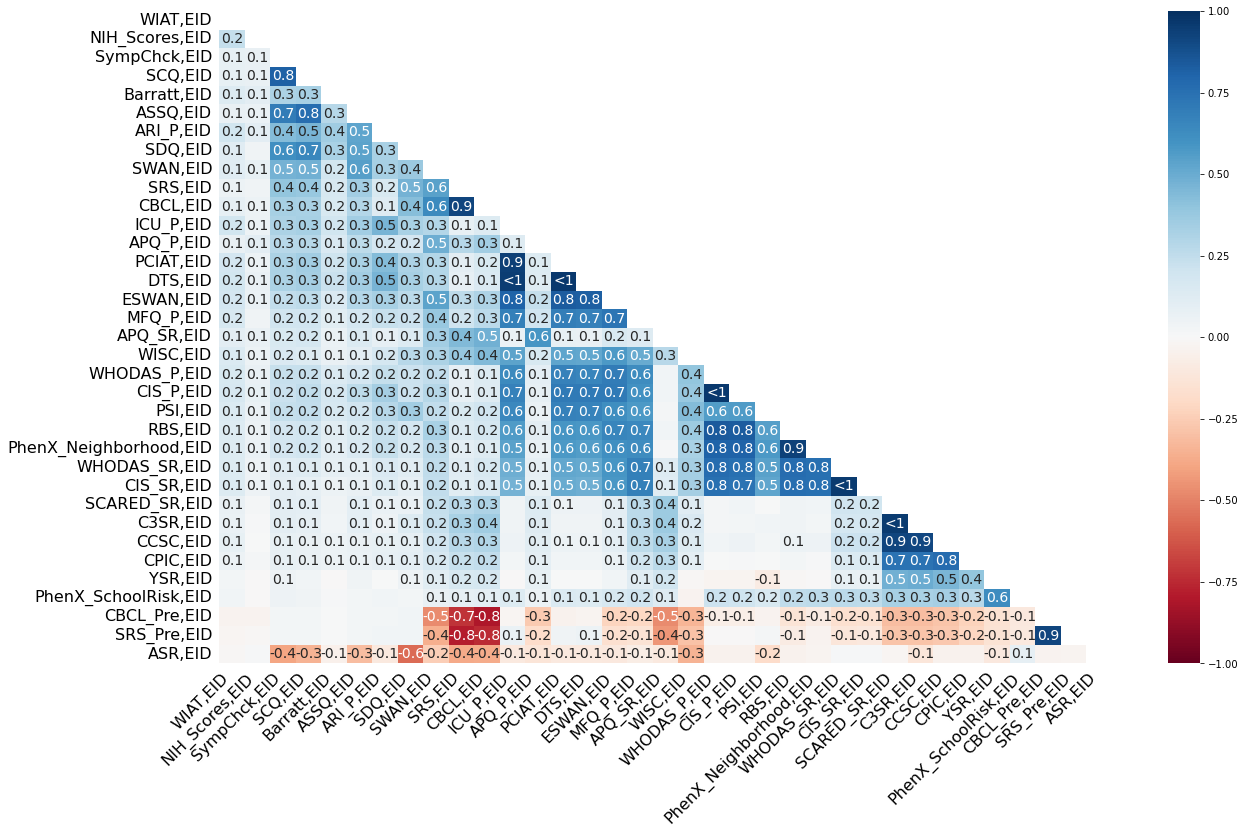

In [137]:
# Check if missingness of assessments is correlated

import missingno as msno
msno.heatmap(full_wo_underscore[relevant_EID_list])

plt.savefig(data_output_dir + 'msno-heatmap.png')

In [138]:
missing_df = full_wo_underscore[relevant_EID_list].iloc[:, [i for i, n in enumerate(np.var(full_wo_underscore[relevant_EID_list].isnull(), axis='rows')) if n > 0]]
corr_mat = missing_df.isnull().corr()

In [139]:
corr_mat_flat = pd.melt(corr_mat.reset_index(), id_vars=['index'], value_vars=[x for x in corr_mat.columns if x!= "index"])
corr_mat_flat[(corr_mat_flat["value"] != 1) & (abs(corr_mat_flat["value"]) > 0.7)].sort_values(by="index")

# ==> 
# Strong (>0.7) positive and negative correlations:
#
# ASSQ (parents of all participants): ~ SympChck (parents of all participants), SCQ (parents of all participants)
# C3SRQ (>8yo): ~ >8yo
# CBCL: !~ CBCL_Pre, !~ SRS_Pre, ~SRS
# CBCL_Pre: ~ SRS_Pre, !~ CBCL, !~ SRS
# CCSC (>8yo): ~ >8yo
# CIS_P (parents of all participants): ~WHODAS_SR (all participants), PhenX_Neighborhood (parents of all participants), PCIAT (parents of all participants), RBS (parents of all participants), WHODAS_P (parents of all participants), DTS (parents of all participants), ESWAN (parents of all participants)
# CPIC (>8yo): ~ >8yo
# DTS (parents of all participants): ~ parents of all participants
# ESWAN (parents of all participants): ~ parents of all participants
# ICU_P (parents of all participants): ~ parents of all participants
# MFQ_P (parents of all participants): ~ parents of all participants
# PCIAT (parents of all participants): ~ parents of all participants
# PhenX_Neighborhood (parents of all participants): ~ parents of all participants, WHODAS_SR (all participants)
# RBS (parents of all participants): ~ parents of all participants, WHODAS_SR (all participants)
# SCARED_SR (>8yo): ~ >8yo
# SCQ: ~ ASSQ (parents of all participants), SympChck (parents of all participants)
# SRS: ~ CBCL, !~ CBCL_Pre, SRS_Pre
# SRS_Pre: !~ CBCL, SRS, ~CBCL_Pre
# SympChck (parents of all participants): ~ ASSQ (parents of all participants), SCQ (parents of all participants)
# WHODAS_P (parents of all participants): ~ WHODAS_SR (all participants),  ~ parents of all participants (PhenX_Neighborhood, RBS, CIS_P)
# WHODAS_SR (all participants): ~ parents of all participants (WHODAS_P, PhenX_Neighborhood, RBS, CIS_P)

,index,variable,value
75,"ASSQ,EID","SympChck,EID",0.701047
110,"ASSQ,EID","SCQ,EID",0.765077
1007,"C3SR,EID","CCSC,EID",0.908387
937,"C3SR,EID","SCARED_SR,EID",0.960576
1042,"C3SR,EID","CPIC,EID",0.738944
1130,"CBCL,EID","CBCL_Pre,EID",-0.811272
325,"CBCL,EID","SRS,EID",0.919213
1165,"CBCL,EID","SRS_Pre,EID",-0.749963
382,"CBCL_Pre,EID","CBCL,EID",-0.811272
1187,"CBCL_Pre,EID","SRS_Pre,EID",0.920268


In [140]:
# Check if missing columns are dependent on demographics

age_sex_cols = ["Basic_Demos,Age", "Basic_Demos,Sex"]
data_for_na_report = full_wo_underscore.copy()
data_for_na_report[relevant_EID_list] = data_for_na_report[relevant_EID_list].notnull().astype('int')

data_for_na_report[age_sex_cols] = data_for_na_report[age_sex_cols].astype('float')

corr_matrix = data_for_na_report[relevant_EID_list + age_sex_cols].corr().drop(labels=age_sex_cols)
corr_matrix_styled = corr_matrix[age_sex_cols].style.background_gradient(cmap='coolwarm', vmin=-0.8, vmax=0.8).format(precision=2)

import dataframe_image as dfi
dfi.export(corr_matrix_styled, data_output_dir + 'missingness-demos-corr.png')

corr_matrix[age_sex_cols].to_csv(data_output_dir + 'missingness-demos-corr.csv')

corr_matrix_styled

# ==> Strong (>0.7 only YSR, ages 11-17), no sex corr > abs(0.5)

[1005/094650.714505:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmpvg10ml75/temp.png.
[1005/094652.005259:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmpuaz7jbv6/temp.png.


,"Basic_Demos,Age","Basic_Demos,Sex"
"Basic_Demos,EID",nan,nan
"WIAT,EID",-0.00,-0.02
"NIH_Scores,EID",0.00,-0.02
"SympChck,EID",-0.20,-0.02
"SCQ,EID",-0.19,-0.02
"Barratt,EID",-0.06,0.02
"ASSQ,EID",-0.16,-0.02
"ARI_P,EID",-0.08,-0.01
"SDQ,EID",-0.29,-0.03
"SWAN,EID",0.02,-0.02


In [141]:
# Check if missing columns are dependent on barratt

barratt_cols = ["Barratt,Barratt_Total", "Barratt,Barratt_Total_Edu", "Barratt,Barratt_Total_Occ"]
data_for_na_report[barratt_cols] = data_for_na_report[barratt_cols].astype('float')
corr_matrix = data_for_na_report[relevant_EID_list + barratt_cols].corr().drop(labels=barratt_cols)
corr_matrix_styled = corr_matrix[barratt_cols].style.background_gradient(cmap='coolwarm', vmin=-0.8, vmax=0.8).format(precision=2)

import dataframe_image as dfi
dfi.export(corr_matrix_styled, data_output_dir + 'missingness-barratt-corr.png')

corr_matrix[barratt_cols].to_csv(data_output_dir + 'missingness-barratt-corr.csv')

corr_matrix_styled

# ==> No strong correlation

[1005/094654.037949:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmp3y0a5958/temp.png.
[1005/094655.301896:INFO:headless_shell.cc(660)] Written to file /var/folders/63/96f7chcx7qq5r9fq4x0x72bw0000gq/T/tmp1v_e7do9/temp.png.


,"Barratt,Barratt_Total","Barratt,Barratt_Total_Edu","Barratt,Barratt_Total_Occ"
"Basic_Demos,EID",nan,nan,nan
"WIAT,EID",0.00,0.03,-0.00
"NIH_Scores,EID",0.00,0.01,-0.00
"SympChck,EID",0.05,0.07,0.04
"SCQ,EID",0.06,0.08,0.05
"Barratt,EID",nan,nan,nan
"ASSQ,EID",0.05,0.08,0.04
"ARI_P,EID",0.10,0.09,0.09
"SDQ,EID",0.04,0.06,0.03
"SWAN,EID",0.04,0.07,0.03


In [142]:
# Diagnosis counts (any position)
diag_distrib = data_up_to_SCARED[["Diag: " +x for x in diags]].sum().sort_values(ascending=False)
display(diag_distrib)

diag_distrib.to_csv("data/output/diag_distrib.csv")

Diag: ADHD-Inattentive Type                                                          583
Diag: ADHD-Combined Type                                                             549
Diag: Specific Learning Disorder with Impairment in Reading                          406
Diag: Generalized Anxiety Disorder                                                   313
Diag: Oppositional Defiant Disorder                                                  291
Diag: Autism Spectrum Disorder                                                       272
Diag: Language Disorder                                                              234
Diag: Social Anxiety (Social Phobia)                                                 218
Diag: Specific Phobia                                                                207
Diag: Specific Learning Disorder with Impairment in Mathematics                      187
Diag: Enuresis                                                                       183
Diag: Specific Learni